# Anime Classifier with Naive Bayes
<br>

## Goal
Classify animes into genres using their synopsis.

| Synopsis | Classification
| --- | --- |
| Centuries ago, mankind was slaughtered to near extinction by monstrous humanoid creatures called titans[...] | Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen |
<br>

## What is the Naive Bayes algorithm?
The algorithm we are going to use is the Multinomial Naive Bayes algorithm. It is a simple probabilistic classifier based on applying Bayes' theorem.
<br><br>
Bayes' theorem describes a conditional probability: the probability of an event happening given the fact that another event happened.

$$P(A|B) = \frac{P(B|A)P(A)}{P(B)}$$
<br>
The general idea, applied to our problem, is that we are going to compute the "probability" of an anime being of or not being of a particular genre given its synopsis, which means given each word in its synopsis. The highest "probability" between the two will be our verdict.

The algorithm learns from previously classified animes to classify new ones.
We will explain more in the section we are going to use the algorithm into.
<br><br>

## What is our accuracy goal?
We would like to have an accuracy per genre of at least 80%. It means that, for a given genre, at least 80% of animes were assigned an accurate presence or absence value for this genre. 

We will not define our accuracy as the percentage of animes for which we guess perfectly the presence and absence of all the genres, this would be extremely hard to accomplish with this algorithm as we have 43 genres.
<br><br>

## Steps
* Fetch anime data using an API
* Clean it
* Prepare for the Naive Bayes algorithm
* Apply the algorithm to classify animes into genres
* Analyze our accuracies per anime and per genre in details
* Look for correlations to explore what makes genres easy or hard to predict
* Explore the relationships between genres
* Visualize the most significant words for given genres
* Conclude the project, comment it & visualize the duration of the project

## Imports & Program constants
We start by importing what we will need, as well as declaring some constants:

In [115]:
import requests        # For HTTP requests
import json 
import re              # For Regular Expressions              
from os import path    # To detect the presence of files


# DataFrame tools
import numpy as np
import pandas as pd
import time

# For plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style

# Makes it so that Jupyter displays the returned values after executing a cell,
#even when they are not at the very end of the cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 50)

class Constants:
    FORCE_API_GET = False
    FORCE_COMPUTE_PARAMETERS = False
    ANIMES_CSV_FILENAME = "animes_from_api_more.csv"
    PARAMETERS_FILENAME = "parameters_all_genres_one_page.json"
    PARAMETERS_NO_FILENAME = "parameters_no_all_genres_one_page.json"
    INCLUDE_NSFW_GENRES = False    # Would only ignore them starting at the accuracy per genre analysis step

## Fetching Anime Data using an API
In order to reach our goal, we first need to collect our data. We could either find a database or CSV file, or we could use an API.
Using an API will allow us to update our data as new animes air. I opted for an API as I wanted to practice using them.


The API we will use is [Jikan](https://jikan.docs.apiary.io/), an unofficial API for the website [MyAnimeList](https://myanimelist.net/).
It does no require any authentication.

The only type of request we will use fetches the most popular animes of a specific genre, divided by pages of up to 100 animes ([doc](https://jikan.docs.apiary.io/#reference/0/genre)).
As we want to guarantee having animes of all genres, we will request the first page of each genre.

### Genres
In total, the [Jikan](https://jikan.docs.apiary.io/) API uses 43 genres.
We are also going to implement a setting for us to choose if we want to include or exclude NSFW genres.
If excluded, it will leave us with 36 genres.

In [116]:
genres={'Action','Adventure','Cars','Comedy','Dementia','Demons','Drama','Ecchi','Fantasy'
        ,'Game','Harem','Hentai','Historical','Horror','Josei','Kids','Magic','Martial Arts'
        ,'Mecha','Military','Music','Mystery','Parody','Police','Psychological','Romance',
        'Samurai','School','Sci-Fi','Seinen','Shoujo','Shoujo Ai','Shounen','Shounen Ai',
        'Slice of Life','Space','Sports','Super Power','Supernatural','Thriller','Vampire','Yaoi','Yuri'}

genres_sfw = [g for g in genres if g not in ["Shoujo Ai", "Yuri", "Hentai", "Yaoi", "Shounen Ai", "Ecchi", "Harem"]]
selected_genres = genres if Constants.INCLUDE_NSFW_GENRES else genres_sfw

### Requesting the data

In [117]:
# GET request to get the first page (up to 100) of animes of a genre
def request_genre(genre_id, page=1):
    url = "https://api.jikan.moe/v3/genre/anime/" + str(genre_id) + "/" + str(page)
    return requests.get(url).json()

The response is too long to show here. 
If you want to see what it looks like, you can, in your browser, request the url:
https://api.jikan.moe/v3/genre/anime/1/1

### Parsing the data
The dictionary we get contains a lot of data we don't need. We will isolate the data about the animes themselves with the 'anime' key, where we find a list of animes as dictionaries.

Each anime dictionary has 3 keys we are interested in:
* 'title': string
* 'synopsis': string
* 'genres': list of strings

In [118]:
# Requesting the the first page of the the genre of id 1 (Action)
response = request_genre(1, 1)

# In this example we will extract the title, synopsis and genres of the first anime
anime_dictionaries = response["anime"]
anime_1 = anime_dictionaries[0]
anime_1["title"]
anime_1["synopsis"]
anime_1["genres"]

# We get genres as a list of dictionaries, each dictionary having several keys.
# The name of the genre is the only one we are interested in.
def simplify_genres(genres_dictionaries):
    return [genre_dictionary["name"] for genre_dictionary in genres_dictionaries]  

# The genres values are dictionary themselves. We will only keep the value at the key "name" for each one
simplified_genres = simplify_genres(anime_1["genres"])
print("Simplified genres: " + str(simplified_genres))

'Shingeki no Kyojin'

"Centuries ago, mankind was slaughtered to near extinction by monstrous humanoid creatures called titans, forcing humans to hide in fear behind enormous concentric walls. What makes these giants truly terrifying is that their taste for human flesh is not born out of hunger but what appears to be out of pleasure. To ensure their survival, the remnants of humanity began living within defensive barriers, resulting in one hundred years without a single titan encounter. However, that fragile calm is soon shattered when a colossal titan manages to breach the supposedly impregnable outer wall, reigniting the fight for survival against the man-eating abominations.\r\n\r\nAfter witnessing a horrific personal loss at the hands of the invading creatures, Eren Yeager dedicates his life to their eradication by enlisting into the Survey Corps, an elite military unit that combats the merciless humanoids outside the protection of the walls. Based on Hajime Isayama's award-winning manga, Shingeki no Ky

[{'mal_id': 1,
  'type': 'anime',
  'name': 'Action',
  'url': 'https://myanimelist.net/anime/genre/1/Action'},
 {'mal_id': 38,
  'type': 'anime',
  'name': 'Military',
  'url': 'https://myanimelist.net/anime/genre/38/Military'},
 {'mal_id': 7,
  'type': 'anime',
  'name': 'Mystery',
  'url': 'https://myanimelist.net/anime/genre/7/Mystery'},
 {'mal_id': 31,
  'type': 'anime',
  'name': 'Super Power',
  'url': 'https://myanimelist.net/anime/genre/31/Super_Power'},
 {'mal_id': 8,
  'type': 'anime',
  'name': 'Drama',
  'url': 'https://myanimelist.net/anime/genre/8/Drama'},
 {'mal_id': 10,
  'type': 'anime',
  'name': 'Fantasy',
  'url': 'https://myanimelist.net/anime/genre/10/Fantasy'},
 {'mal_id': 27,
  'type': 'anime',
  'name': 'Shounen',
  'url': 'https://myanimelist.net/anime/genre/27/Shounen'}]

Simplified genres: ['Action', 'Military', 'Mystery', 'Super Power', 'Drama', 'Fantasy', 'Shounen']


### Cleaning synopses
The current format of an anime's synopsis is hard to exploit with the Multinomial Naive Bayes algorithm.

To clean a synopsis, we will:
* Remove special characters
* Remove 'Written by MAL Rewrite' present at the end of each synopsis
* Lowercase it
* Split the string into a list of words
* Only keep valid words

In order to apply the algorithm efficiently, we should not analyze the probabilities linked to the presence or absence of meaningless words, like 'the', 'a', 'of'...

As a simplification, we will only keep words that contain 5 or more characters.
We will also remove the words we will use as column names to prevent conflicts.

In [119]:
# We will ignore the words that refer to genres or column names in our synopses to avoid conflicts
banned_words = set([genre.lower() for genre in genres] + ["title", "synopsis", "genres"]) 
# In order to exclude meaningless words, we only keep words of length 5 or more.
def is_valid(word):
    if word in banned_words or len(word) <= 5: 
        return False
    return True

# Formats a string by removing punctuation, 'written by mal rewrite', extra spaces, lowering it, making a list of valid words
def clean_synopsis(string):
    words = re.sub('\W', ' ', string).replace("written by mal rewrite", "").strip().lower().split()
    valid_words = [word for word in words if is_valid(word)]
    return valid_words

### Simplifying attribute access with Object-Oriented programming
Now that we can access the data we need for each anime, we can simplify the structure.

In [120]:
# We create our own structure to simplify the program and only work with the data we need
class Anime:
    
    def __init__(self, anime_from_json):
        self.title = anime_from_json["title"]
        self.synopsis = clean_synopsis(anime_from_json["synopsis"])
        self.genres = simplify_genres(anime_from_json["genres"])

        
# Takes in the response of the request to get animes of a genre, and returns a list of anime objects
def simplify(animes_of_genre_json):
    animes_json = animes_of_genre_json["anime"]
    animes_objs = [Anime(anime_json) for anime_json in animes_json]
    return animes_objs

anime_objs = simplify(response)
first_anime = anime_objs[0]
print("Title of the first anime object: " + first_anime.title)

Title of the first anime object: Shingeki no Kyojin


### Regrouping anime objects as a DataFrame
In order to apply our machine learning algorithm, we want our data to be contained in a single DataFrame.
Using the library Pandas, we will create a DataFrame, with each row being an anime.

It will have the following columns:
* 'title': strings
* 'synopsis': strings
* 'genres': lists of strings

In [121]:
# Returns a df from anime objects
def get_df(animes):
    titles = [anime.title for anime in animes]
    synopses = [anime.synopsis for anime in animes]
    genres = [anime.genres for anime in animes]
    return pd.DataFrame(data = {"title": titles, "synopsis": synopses, "genres": genres})

get_df(anime_objs).head()

,title,synopsis,genres
0,Shingeki no Kyojin,"[centuries, mankind, slaughtered, extinction, ...","[Action, Military, Mystery, Super Power, Drama..."
1,Sword Art Online,"[virtual, reality, progressed, bounds, massive...","[Action, Adventure, Fantasy, Game, Romance]"
2,Fullmetal Alchemist: Brotherhood,"[something, obtained, something, alchemy, equi...","[Action, Military, Adventure, Comedy, Drama, M..."
3,One Punch Man,"[seemingly, ordinary, unimpressive, saitama, r...","[Action, Sci-Fi, Comedy, Parody, Super Power, ..."
4,Tokyo Ghoul,"[become, merciless, vicious, creatures, called...","[Action, Mystery, Horror, Psychological, Super..."


### Making one function to fetch all the data we need
In this step, we create one function that will execute the complete process of fetching and formating our data.
We will also add the functionality of removing duplicate animes.

In [122]:
# We request the first page of animes of different genres.
# An anime tends to have mutliple genres, so we might end up with duplicates.
def remove_duplicates(animes_list):
    original_len = len(animes_list) 
    singleton = []
    anime_titles = set()
    for i, anime in enumerate(animes_list):
        if anime.title not in anime_titles:
            anime_titles.add(anime.title)
            singleton.append(anime)
    print("Removed " + str(original_len - len(animes_list)) + " duplicates")
    return singleton

# Gets us all the anime data of all specified genre ids as a DataFrame
def fetch_data(genre_ids, pages_per_genre=1):
    anime_groups = []
    for genre_id in genre_ids:
        for page in range(1, pages_per_genre + 1):
            anime_groups.append(simplify(request_genre(genre_id, page)))
            # as we request a lot of data each request, we wait a large amount of time to not flood the API
            time.sleep(4)    
    
    # Our animes are grouped by genre, we ungroup them
    animes = []    
    for group in anime_groups:
        for anime in group:
            animes.append(anime)
                    
    animes = remove_duplicates(animes)
    return get_df(animes)

genres_to_fetch = [1, 2]
fetch_data(genres_to_fetch)

Removed 0 duplicates


,title,synopsis,genres
0,Shingeki no Kyojin,"[centuries, mankind, slaughtered, extinction, ...","[Action, Military, Mystery, Super Power, Drama..."
1,Sword Art Online,"[virtual, reality, progressed, bounds, massive...","[Action, Adventure, Fantasy, Game, Romance]"
2,Fullmetal Alchemist: Brotherhood,"[something, obtained, something, alchemy, equi...","[Action, Military, Adventure, Comedy, Drama, M..."
3,One Punch Man,"[seemingly, ordinary, unimpressive, saitama, r...","[Action, Sci-Fi, Comedy, Parody, Super Power, ..."
4,Tokyo Ghoul,"[become, merciless, vicious, creatures, called...","[Action, Mystery, Horror, Psychological, Super..."
...,...,...,...
157,Magi: Sinbad no Bouken (TV),"[impoverished, village, parthevia, empire, sin...","[Action, Adventure, Fantasy, Magic, Shounen]"
158,Wolf's Rain,"[exists, ancient, legend, gateway, paradise, o...","[Action, Adventure, Drama, Fantasy, Mystery, S..."
159,Satsuriku no Tenshi,"[lifeless, rachel, gardner, wishes, waking, ba...","[Adventure, Horror, Psychological, Thriller]"
160,Yu☆Gi☆Oh! Duel Monsters,"[legend, enigmatic, millennium, puzzle, whoeve...","[Adventure, Game, Shounen]"


### Supporting anime data storaging
As we wait 4 seconds between each genre calls, fetching all our data can be long.
In this last step of fetching our data, we will build a simple save/load system.

* If the CSV file (whose name is specified in the Constants class) is present, load it as our anime data
* If the CSV file is absent, fetch anime data (first page of each genre) and save it as a CSV file

In [123]:
# We only fetch API data if we did not already do it and saved it, or if we set it to do it regardless (new data?)
if not path.isfile(Constants.ANIMES_CSV_FILENAME) or Constants.FORCE_API_GET:
    print("Fetching & saving anime data")
    all_ids = [id + 1 for id in range(len(genres))]
    animes = fetch_data(all_ids, 1)
    animes.to_csv(Constants.ANIMES_CSV_FILENAME, index = False)
else:
    print("Loading anime data")
    animes = pd.read_csv(Constants.ANIMES_CSV_FILENAME)
    # the synopsis and genres columns are saved and loaded as strings, not lists of strings. We need to convert them back to lists
    animes["synopsis"] = animes["synopsis"].str.replace('[', '').str.replace(']', '').str.replace("'", '').str.replace(',', '').str.split()
    animes["genres"] = animes["genres"].str.replace('[', '').str.replace(']', '').str.replace("'", '').str.replace(', ', ',').str.split(',')

print("Loaded " + str(animes.shape[0]) + " animes")
animes.head()

Loading anime data
Loaded 2331 animes


,title,synopsis,genres
0,Shingeki no Kyojin,"[centuries, mankind, slaughtered, extinction, ...","[Action, Military, Mystery, Super Power, Drama..."
1,Sword Art Online,"[virtual, reality, progressed, bounds, massive...","[Action, Adventure, Fantasy, Game, Romance]"
2,Fullmetal Alchemist: Brotherhood,"[something, obtained, something, alchemy, equi...","[Action, Military, Adventure, Comedy, Drama, M..."
3,One Punch Man,"[seemingly, ordinary, unimpressive, saitama, r...","[Action, Sci-Fi, Comedy, Parody, Super Power, ..."
4,Tokyo Ghoul,"[become, merciless, vicious, creatures, called...","[Action, Mystery, Horror, Psychological, Super..."


We now have a DataFrame containing data on 2332 animes that we got from getting the first page of animes of each genre and removing the duplicates.

### Cleaning our 'genres' column
Our 'genres' column contains lists of genres. We can make applying the algorithm easier by splitting this data into multiple columns.

For each genre, we will create a column of this name. If an anime is of this genre, it will have the value True. Otherwise, it will have the value False.

In [124]:
# Creates a column per genre, and sets it to TRUE if the anime is of this genre, FALSE otherwise
def clean_genres(df, genres):
    for genre in genres:
        df[genre] = df["genres"].apply(lambda genre_list: genre in genre_list)

clean_genres(animes, genres)
animes.head()

,title,synopsis,genres,Shoujo,Harem,Slice of Life,Historical,Magic,Yuri,Mecha,Seinen,Ecchi,Super Power,Demons,Yaoi,Josei,Military,Horror,Police,Martial Arts,Comedy,Fantasy,Hentai,Sports,Shoujo Ai,Thriller,Supernatural,Romance,Action,School,Samurai,Sci-Fi,Drama,Music,Psychological,Space,Cars,Shounen Ai,Vampire,Kids,Adventure,Mystery,Shounen,Dementia,Game,Parody
0,Shingeki no Kyojin,"[centuries, mankind, slaughtered, extinction, ...","[Action, Military, Mystery, Super Power, Drama...",False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,True,False,False,False
1,Sword Art Online,"[virtual, reality, progressed, bounds, massive...","[Action, Adventure, Fantasy, Game, Romance]",False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False
2,Fullmetal Alchemist: Brotherhood,"[something, obtained, something, alchemy, equi...","[Action, Military, Adventure, Comedy, Drama, M...",False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,True,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,True,False,False,False
3,One Punch Man,"[seemingly, ordinary, unimpressive, saitama, r...","[Action, Sci-Fi, Comedy, Parody, Super Power, ...",False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True
4,Tokyo Ghoul,"[become, merciless, vicious, creatures, called...","[Action, Mystery, Horror, Psychological, Super...",False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,True,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,False,False


## Training & Test Set
A good practice when using machine learning algorithms is to split our data in two sets:
* The training set that our algorithm will learn from (80% of the rows)
* The test set that our algorithm will process with its knowledge (20% of the rows)

In [125]:
# Randomizes the dataset
data_randomized = animes.sample(frac = 1, random_state = 1)    # By setting random_state = 1, we make our work reproducible

# Calculates the index for the split (80%-20%)
training_test_index = round(len(data_randomized) * 0.8)

# Splitting the data
training_set = data_randomized[:training_test_index].reset_index(drop=True)
test_set = data_randomized[training_test_index:].reset_index(drop=True)

print("Training set size: " + str(training_set.shape[0]))
print("Test set size: " + str(test_set.shape[0]))

Training set size: 1865
Test set size: 466


We have 1865 animes to learn from, and we will test our algorithm on 466 other animes.

## Learning from the training set: Multinomial Naive Bayes
Now that we have isolated our training set, we can proceed to learn from it.
The algorithm we are going to use is the Multinomial Naive Bayes algorithm. It is a simple probabilistic classifier based on applying Bayes' theorem.

Bayes' theorem describes a conditional probability: the probability of an event given happening given the fact that another event happened.

$$P(A|B) = \frac{P(B|A)P(A)}{P(B)}$$

The general idea, applied to our problem, is that we are going to compute the "probability" of an anime being of or not being of a particular genre given its synopsis, which means given each word in its synopsis. The highest "probability" between the two will be our verdict.

The algorithm learns from previously classified animes to classify new ones.

### Naive Bayes formulas
The theorem tells us that:
* The probability for a synopsis to be of a genre given each one of its words is proportional to the general probability of this genre multiplied by the factor of the probabilities of each of its word given the genre:
<br>
$$P(Genre|w_1, w_2, ..., w_n) \propto P(Genre)\prod_{i=1}^{n}P(w_i|Genre)$$
<br>
* The same is true for the probability of not being of this genre:
<br>
$$P(Genre^\mathsf{c}|w_1, w_2, ..., w_n) \propto P(Genre^\mathsf{c})\prod_{i=1}^{n}P(w_i|Genre^\mathsf{c})$$

#### How do we make use of it?
We compute the two values on the right hand side, and the biggest one is going to determine if we think the genre is present or absent:

* $P(Genre)\prod_{i=1}^{n}P(w_i|Genre) > P(Genre^\mathsf{c})\prod_{i=1}^{n}P(w_i|Genre^\mathsf{c})$
$<=>$
We think that this anime is of this genre
<br><br>
    
* $P(Genre)\prod_{i=1}^{n}P(w_i|Genre) < P(Genre^\mathsf{c})\prod_{i=1}^{n}P(w_i|Genre^\mathsf{c})$ $<=>$
We think that this anime is not of this genre
<br><br>
* If the values are equal (which should be extremely rare), then our algorithm cannot decide.
<br><br>
    
It also tells us that:
* The probability of a word given a genre is:
$$P(w_i|Genre)=\frac{N_{w_i|Genre}+\alpha}{N_{Genre}+\alpha\cdot N_{Vocabulary}}$$
<br>

* The same is true for a word given not a genre:
$$P(w_i|Genre^\mathsf{c})=\frac{N_{w_i|Genre^\mathsf{c}}+\alpha}{N_{Genre^\mathsf{c}}+\alpha\cdot N_{Vocabulary}}$$

With:

$N_{w_i|Genre}$  as the number of times the word $w_i$ was seen in synopses of the given genre.

$N_{w_i|Genre^\mathsf{c}}$ as the number of times the word $w_i$ was seen in synopses of all other genres.

$N_{Genre}$ as the number of animes of the given genre.

$N_{Genre^\mathsf{c}}$ as the number of animes not of the given genre.

$N_{Vocabulary}$ as the number of unique words across all synopses.

$\alpha$ as the chosen smoothing factor.

## Computing constants
Most of the values in the formulas seen above will not change from a synopsis to another.

### Vocabulary
We will first need to access the vocabulary. Here it is a collection of all the unique words across all synopses.

In [126]:
# Creates a list of all the words present in synopses
# Synopses are already curated to only contain valid words
def get_vocabulary(series):
    vocab = []
    for synopsis in series:
        for word in synopsis:
            vocab.append(word)
    return set(vocab)

vocabulary = get_vocabulary(training_set["synopsis"])
len(vocabulary)

13521

### Adding word occurrences count columns
The main data our algorithm needs to learn is the number of occurrences of each word in synopses.

For each word, we will add a column counting the number occurrences of this word there are in the synopses of all animes.

In [127]:
# Creates an initial dictionary associating words with a list of n zeros, n beign the number of rows (rows=animes)
word_counts_per_synopsis = {unique_word: [0] * len(training_set["synopsis"]) for unique_word in vocabulary}

# We then populate our dictionary with the number of occurences
for index, synopsis in enumerate(training_set["synopsis"]):
    for word in synopsis:
        word_counts_per_synopsis[word][index] += 1

# We finally convert it to a DataFrame for concat purposes
word_counts = pd.DataFrame(word_counts_per_synopsis)
word_counts.head()

,avoiding,upperclassmen,horrifying,punishing,isidro,entrusts,rejoin,gamble,emishi,setsuko,maelstrom,bargain,lockdown,kintaro,flighty,katachi,kurono,doubts,training,tsukaima,dramaturgie,rygart,vaporizing,cadets,ryuujirou,...,bestows,periods,tenten,loveable,embodies,adherence,focusing,haywire,beginner,intercourse,chiharu,sanjou,assuming,attended,fukushima,yukinojo,vegetables,bookworm,stalks,arslan,fleuranza,beforehand,bullets,rentaro,doujinshi
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [128]:
# We can now concatenate our title, synopsis and genres data with our new word occurences data
training_set_clean = pd.concat([training_set, word_counts], axis=1)
training_set_clean.head()

,title,synopsis,genres,Shoujo,Harem,Slice of Life,Historical,Magic,Yuri,Mecha,Seinen,Ecchi,Super Power,Demons,Yaoi,Josei,Military,Horror,Police,Martial Arts,Comedy,Fantasy,Hentai,Sports,Shoujo Ai,...,bestows,periods,tenten,loveable,embodies,adherence,focusing,haywire,beginner,intercourse,chiharu,sanjou,assuming,attended,fukushima,yukinojo,vegetables,bookworm,stalks,arslan,fleuranza,beforehand,bullets,rentaro,doujinshi
0,Akame ga Kill!,"[covert, assassination, branch, revolutionary,...","[Action, Adventure, Drama, Fantasy, Shounen]",False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Boku no Hero Academia,"[appearance, quirks, discovered, powers, stead...","[Action, Comedy, School, Shounen, Super Power]",False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Koukaku Kidoutai: Shin Movie,"[following, nuclear, newport, killing, dealer,...","[Action, Sci-Fi, Police, Psychological, Mecha]",False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Kakuriyo no Yadomeshi,"[female, college, student, inherited, deceased...","[Demons, Supernatural]",False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Fate/stay night: Unlimited Blade Works,"[battle, royale, masters, masters, through, co...","[Action, Fantasy, Magic, Supernatural]",False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Calculating Constants
Most of the variables used in the formulas can be computed in advance. By doing this, we can make applying the algorithm to a synopsis really efficient.

For each genre, we need:
* $P(Genre)$: the probability that an arbitrary anime is of this genre
* $P(Genre^\mathsf{c})$: the probability that an arbitrary anime is not of this genre
* $N_{words|Genre}$: the total number of words in all synopses of animes of this genre
* $N_{words|Genre^\mathsf{c}}$: the total number of words in all synopses of animes of all other genres

In addition, we set:
* $\alpha$ as the smoothing factor to 1 (Laplace Smoothing)
* $N_{vocabulary}$ as the total number of unique words


Let's compute:
* $P(Genre)$: the probability that an arbitrary anime is of this genre
* $P(Genre^\mathsf{c})$: the probability that an arbitrary anime is not of this genre

In [129]:
genre_p = {}
for genre in genres:
    genre_p[genre] = (training_set_clean[genre]).sum() / len(training_set_clean)

genre_not_p = {}
for genre in genres:
    genre_not_p[genre] = (training_set_clean[genre] == False).sum() / len(training_set_clean)
                
genre_p

{'Shoujo': 0.058981233243967826,
 'Harem': 0.06916890080428954,
 'Slice of Life': 0.11206434316353887,
 'Historical': 0.07882037533512064,
 'Magic': 0.07613941018766757,
 'Yuri': 0.018230563002680965,
 'Mecha': 0.07935656836461126,
 'Seinen': 0.09115281501340483,
 'Ecchi': 0.08525469168900804,
 'Super Power': 0.064343163538874,
 'Demons': 0.05254691689008043,
 'Yaoi': 0.01876675603217158,
 'Josei': 0.04075067024128686,
 'Military': 0.06541554959785523,
 'Horror': 0.06541554959785523,
 'Police': 0.04664879356568365,
 'Martial Arts': 0.05040214477211796,
 'Comedy': 0.4,
 'Fantasy': 0.21179624664879357,
 'Hentai': 0.057908847184986595,
 'Sports': 0.05844504021447721,
 'Shoujo Ai': 0.03163538873994638,
 'Thriller': 0.043431635388739946,
 'Supernatural': 0.19517426273458446,
 'Romance': 0.23967828418230563,
 'Action': 0.3903485254691689,
 'School': 0.17587131367292225,
 'Samurai': 0.04128686327077748,
 'Sci-Fi': 0.18123324396782842,
 'Drama': 0.2579088471849866,
 'Music': 0.0584450402144772

* $N_{words|Genre}$: the total number of words in all synopses of animes of this genre
* $N_{words|Genre^\mathsf{c}}$: the total number of words in all synopses of animes of all other genres

In [130]:
# Associates genres to the number of words in all synopses of this genre
genre_n_words = {}    
for genre in genres:
    rows_of_this_genre = training_set_clean[training_set_clean[genre]]
    genre_n_words[genre] = rows_of_this_genre["synopsis"].apply(len).sum()
    
# Associates genres to the number of words in all synopses not of this genre
total_words = training_set_clean["synopsis"].apply(len).sum()
not_genre_n_words = {}    
for genre in genres:
    not_genre_n_words[genre] = total_words - genre_n_words[genre]
  
genre_n_words

{'Shoujo': 4599,
 'Harem': 5564,
 'Slice of Life': 8398,
 'Historical': 5730,
 'Magic': 6227,
 'Yuri': 779,
 'Mecha': 6942,
 'Seinen': 7267,
 'Ecchi': 6096,
 'Super Power': 5241,
 'Demons': 3871,
 'Yaoi': 876,
 'Josei': 2326,
 'Military': 6146,
 'Horror': 4426,
 'Police': 3454,
 'Martial Arts': 3432,
 'Comedy': 29582,
 'Fantasy': 17286,
 'Hentai': 3000,
 'Sports': 4173,
 'Shoujo Ai': 1700,
 'Thriller': 3046,
 'Supernatural': 15074,
 'Romance': 18934,
 'Action': 31593,
 'School': 14070,
 'Samurai': 2367,
 'Sci-Fi': 15489,
 'Drama': 20857,
 'Music': 3538,
 'Psychological': 6035,
 'Space': 3876,
 'Cars': 1639,
 'Shounen Ai': 1831,
 'Vampire': 2939,
 'Kids': 3633,
 'Adventure': 14510,
 'Mystery': 9090,
 'Shounen': 15253,
 'Dementia': 1715,
 'Game': 3142,
 'Parody': 3451}

* $\alpha$: the smoothing factor to 1 (Laplace Smoothing)
* $N_{vocabulary}$: the total number of unique words

In [131]:
alpha = 1
n_vocabulary = len(vocabulary)
n_vocabulary

13521

### Calculating Parameters
Now that our constants are computed, we can proceed to compute the parameters.

For each combination of word and genre, we will compute:
* $P(word|Genre)$: the probability to encounter this word in a synopsis of an anime of this genre
* $P(word|Genre^\mathsf{c})$: the probability to encounter this word in a synopsis of any other genre

We will also include a few lines of code to keep track of how long the computation took.

In [132]:
def compute_parameters():
    task_start_time = time.perf_counter()
    
    # Each one of these two variables stores a dictionary having the genres as keys. 
    # Each genre is then linked to another dictionary that will store, for each unique word, the probability associated.
    # There is an example in the next code cell
    parameters = {genre: {unique_word:0 for unique_word in vocabulary} for genre in genres}
    parameters_no = {genre: {unique_word:0 for unique_word in vocabulary} for genre in genres}
    
    for word in vocabulary:
        for genre in genres:

            # P(word|genre)
            rows_of_this_genre = training_set_clean[training_set_clean[genre]]
            n_word_given_genre = rows_of_this_genre[word].sum()    # number of occurences of the treated word in synopses of this genre
            p_word_given_genre = (n_word_given_genre + alpha) / (genre_n_words[genre] + alpha*n_vocabulary)
            parameters[genre][word] = p_word_given_genre

            # P(word|not genre)
            rows_not_of_this_genre = training_set_clean[training_set_clean[genre] == False]
            n_word_given_not_genre = rows_not_of_this_genre[word].sum()
            p_word_given_not_genre = (n_word_given_not_genre + alpha) / (not_genre_n_words[genre] + alpha*n_vocabulary)
            parameters_no[genre][word] = p_word_given_not_genre

    task_duration = time.perf_counter() - task_start_time
    total_operations = n_vocabulary * len(genres)
    duration_per_operation = task_duration / total_operations
    print("Computing the parameters took " + str(round(task_duration, 2)) + " seconds for " + str(total_operations) + " operations") 
    print(str(round(duration_per_operation * 1000, 2)) + " miliseconds per operation")
    
    return parameters, parameters_no

### Supporting parameters storaging
Computing the parameters can be extremely long. As an example, computing the currently used parameters with 1865 animes, 31521 unique words and 43 genres took 21 hours and 36 minutes.

It would be cumbersome to have to compute the parameters each time after re-opening the notebook. To remedy this, we will save the parameters in two JSON files after computing them, and load them instead when the files are present.

In [133]:
def save_parameters():
    print("Saving parameters")
    with open(Constants.PARAMETERS_FILENAME, 'w', encoding ='utf-8') as f:
        json.dump(parameters, f, ensure_ascii = False, indent = 4)
    with open(Constants.PARAMETERS_NO_FILENAME, 'w', encoding ='utf-8') as f:
        json.dump(parameters_no, f, ensure_ascii = False, indent = 4)
        
def load_parameters():
    print("Loading parameters")
    params, params_no = None, None
    with open(Constants.PARAMETERS_FILENAME, 'r', encoding = 'cp850') as f:
        params = json.load(f)
    with open(Constants.PARAMETERS_NO_FILENAME, 'r', encoding = 'cp850') as n:
        params_no = json.load(n)
    return params, params_no

# If we already computed our parameters and saved them locally, we load them. Otherwise we compute and save them
def get_parameters():
    if path.isfile(Constants.PARAMETERS_FILENAME) and path.isfile(Constants.PARAMETERS_NO_FILENAME) and not Constants.FORCE_COMPUTE_PARAMETERS:
        parameters, parameters_no = load_parameters()
    else:
        parameters, parameters_no = compute_parameters()
        save_parameters()
    return parameters, parameters_no

parameters, parameters_no = get_parameters()

Loading parameters


### Classifying
We are now ready to implement the formula.
For each anime, and for each genre, we compute two "probabilities":
* The "probability" that its synopsis is of this genre
* The "probability" that its synopsis is not of this genre

The highest value will define whether the algorithm thinks that this anime is of this genre or not of this genre.

These values are linked to probabilities but are not really probabilities themselves. It does not matter for us, as simply knowing which one is the largest allows us to classify synopses.

#### Computing classification values

In [134]:
# For each genre, computes the "probability" that a given synopsis is of this genre or not
# Returns the result as two dictionaries: one for the "probabilities" of being of a genre, the other for not being of a genre
def compute_classification_values(synopsis):    
    # Note: synopsis is already cleaned - it's a list of valid words
    
    p_genre_given_synopsis = {genre: genre_p[genre] for genre in genres}            # just a copy of genre_p initially
    p_not_genre_given_synopsis = {genre: genre_not_p[genre] for genre in genres}    # just a copy of genre_not_p initially
    
    for word in synopsis:
        for genre in genres:
            if word in parameters[genre]:
                proba = parameters[genre][word]
                p_genre_given_synopsis[genre] *= proba
            if word in parameters_no[genre]:
                proba = parameters_no[genre][word]
                p_not_genre_given_synopsis[genre] *= proba
    # Now these dictionaries contain the "probabilities" we need
                
    return p_genre_given_synopsis, p_not_genre_given_synopsis

# Simple example
synopsis = ["attack", "defense", "shield", "mystery", "unknown", "hidden"]
classification_values = compute_classification_values(synopsis)
classification_values

({'Shoujo': 7.2465972361181355e-22,
  'Harem': 7.867604870080608e-21,
  'Slice of Life': 1.5947634114593137e-21,
  'Historical': 6.67759456298881e-21,
  'Magic': 7.301068166590488e-21,
  'Yuri': 1.219494609350346e-22,
  'Mecha': 5.4143680150433965e-20,
  'Seinen': 7.513746225304687e-21,
  'Ecchi': 3.0989833718546534e-20,
  'Super Power': 5.812005900107338e-21,
  'Demons': 4.953257033454984e-22,
  'Yaoi': 3.034095071019159e-23,
  'Josei': 3.26204128688769e-22,
  'Military': 1.6807851451953546e-19,
  'Horror': 1.8972101537028906e-21,
  'Police': 1.787249818087615e-20,
  'Martial Arts': 3.887227539323364e-21,
  'Comedy': 2.059665163790193e-19,
  'Fantasy': 2.637818746611548e-19,
  'Hentai': 3.764031509400412e-22,
  'Sports': 1.3479616559215207e-22,
  'Shoujo Ai': 4.646634276828076e-22,
  'Thriller': 2.0880364316969435e-22,
  'Supernatural': 2.5088993641759656e-19,
  'Romance': 6.853132892958098e-20,
  'Action': 6.295461720565407e-18,
  'School': 5.3455706132183013e-20,
  'Samurai': 3.9150

We see that the value for being an "Action" anime is $P(Action|synopsis) = 2.142639337327503e-11$, and the value for not being it is $P(Action^\mathsf{c}|synopsis) = 7.13095579321836e-13$.

$P(Action|synopsis) > P(Action^\mathsf{c}|synopsis)$ so, according to our algorithm, the anime having this synopsis is more likely to be classified as Action than not.

$P(Slice of Life|synopsis) < P(Slice of Life^\mathsf{c}|synopsis)$ so, according to our algorithm, the anime having this synopsis more likely to not be a Slice of Life than being one.

#### Extracting the classification's outcome
Now that we have our classification values, we can extract an array containing the genres for which we have a higher probability of having it than not.

In [135]:
# Sorts a dictionary by its values
def sort_dictio(d, descending=True):
    return {k: v for k, v in sorted(d.items(), key=lambda item: item[1], reverse = descending)}

# Returns a dictionary associating each selected genre (P(genre|synopsis) > P(not_genre|synopsis)) to its confidence
# Confidence translates by how much (%) the proba of being in this genre was superior to not being in this genre given the synopsis 
def extract_predicted_genres(classification_values):
    p, no_p = classification_values
    genres_classified = {}
    for k, v in p.items():
        if v > no_p[k]:        
            confidence = (v - no_p[k]) / (no_p[k]) * 100   
            genres_classified[k] = confidence
    return sort_dictio(genres_classified)

# Returns an array of predicted genres, ordered by confidence
# Can be used as df["predicted_genres"] = df["synopsis"].apply(get_predicted_genres_array)
def get_predicted_genres_array(synopsis):
    classification_values = compute_classification_values(synopsis)
    predicted_genres = extract_predicted_genres(classification_values)
    selected_genres_array = list(predicted_genres.keys())
    return selected_genres_array

get_predicted_genres_array(["basketball", "concert", "orchestra"])    # New example, directly simplified

['Music', 'School', 'Comedy', 'Drama']

We see that, for an anime having the words "Basketball", "Concert" and "Orchestra" as its synopsis, the algorithm thinks that the genres of this anime sorted by descending confidence are "Music", "School", "Comedy" and "Drama".

### Applying our classification to all the test set animes

In [136]:
# Applies our classification to all the rows (rows=animes) of a DataFrame
# The result is stored in the new column "predicted_genres" as an array
def classify_all(df):
    df["predicted_genres"] = df["synopsis"].apply(get_predicted_genres_array)

t = test_set.copy()
classify_all(t)
t[["title", "synopsis", "genres", "predicted_genres"]].tail()

,title,synopsis,genres,predicted_genres
461,Terra Formars: Revenge,"[formars, revenge, members, continue, against,...","[Action, Sci-Fi, Space, Horror, Drama, Seinen]","[Action, Sci-Fi, Drama]"
462,Donten ni Warau,"[swords, outlawed, eleventh, mighty, populatio...","[Action, Historical, Shoujo, Supernatural]","[Action, Adventure]"
463,Tsubasa Chronicle,"[during, excavation, mysterious, country, syao...","[Action, Adventure, Fantasy, Magic, Romance, S...","[Fantasy, Adventure]"
464,Hei Mao Jing Zhang (1992),"[series, follows, officer, adventures, around,...","[Action, Adventure, Cars, Comedy, Kids, Police]","[Comedy, Police, Action, Adventure]"
465,Furusato Saisei: Nippon no Mukashibanashi,"[culture, japanese, listening, stories, repeat...","[Historical, Kids, Supernatural]",[]


## Measuring our accuracy

### Cleaning the classifications
The array structure we are using to store the predicted genres is not the easiest one to process.
Let's split it per unique genre:

In [137]:
# Creates two boolean columns per genre:
# - "[genre]_prediction" is True if the genre was predicted as present, False otherwise
# - "[genre]_prediction_is_accurate" is True if the genre prediction is accurate, False otherwise
def clean_classification(df):
    for genre in genres:
        df[genre + "_prediction"] = df["predicted_genres"].apply(lambda predicted_genres: genre in predicted_genres)
        df[genre + "_prediction_is_accurate"] = df[genre + "_prediction"] == df[genre]

clean_classification(t)
t.tail()

,title,synopsis,genres,Shoujo,Harem,Slice of Life,Historical,Magic,Yuri,Mecha,Seinen,Ecchi,Super Power,Demons,Yaoi,Josei,Military,Horror,Police,Martial Arts,Comedy,Fantasy,Hentai,Sports,Shoujo Ai,...,Music_prediction_is_accurate,Psychological_prediction,Psychological_prediction_is_accurate,Space_prediction,Space_prediction_is_accurate,Cars_prediction,Cars_prediction_is_accurate,Shounen Ai_prediction,Shounen Ai_prediction_is_accurate,Vampire_prediction,Vampire_prediction_is_accurate,Kids_prediction,Kids_prediction_is_accurate,Adventure_prediction,Adventure_prediction_is_accurate,Mystery_prediction,Mystery_prediction_is_accurate,Shounen_prediction,Shounen_prediction_is_accurate,Dementia_prediction,Dementia_prediction_is_accurate,Game_prediction,Game_prediction_is_accurate,Parody_prediction,Parody_prediction_is_accurate
461,Terra Formars: Revenge,"[formars, revenge, members, continue, against,...","[Action, Sci-Fi, Space, Horror, Drama, Seinen]",False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,...,True,False,True,False,False,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True
462,Donten ni Warau,"[swords, outlawed, eleventh, mighty, populatio...","[Action, Historical, Shoujo, Supernatural]",True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,True,False,True,False,True,False,True,False,True,False,True,False,True,True,False,False,True,False,True,False,True,False,True,False,True
463,Tsubasa Chronicle,"[during, excavation, mysterious, country, syao...","[Action, Adventure, Fantasy, Magic, Romance, S...",False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,...,True,False,True,False,True,False,True,False,True,False,True,False,True,True,True,False,True,False,False,False,True,False,True,False,True
464,Hei Mao Jing Zhang (1992),"[series, follows, officer, adventures, around,...","[Action, Adventure, Cars, Comedy, Kids, Police]",False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,...,True,False,True,False,True,False,False,False,True,False,True,False,False,True,True,False,True,False,True,False,True,False,True,False,True
465,Furusato Saisei: Nippon no Mukashibanashi,"[culture, japanese, listening, stories, repeat...","[Historical, Kids, Supernatural]",False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,True,False,True,False,True,False,True,False,True,False,True,False,False,False,True,False,True,False,True,False,True,False,True,False,True


## Accuracy per anime
We will assign an accuracy to each anime.
This accuracy is defined by the percentage of genres of this anime that were predicted accurately.

For example:
* There are 3 genres in total: "A", "B and "C"
* Our anime is of the genres "A" and "C"
* We predicted the genre "C"
* Our accuracy is about 66.7%

| | A is present | B is present | C is present | Accuracy
| --- | --- | --- | --- | --- |
| reality | True | False | True
| prediction | False | False | True
| prediction is accurate | False | True | True | 2 True out of 3 = 66.7% accuracy


In [138]:
# Adds the column "accuracy" to the df, specifying the accuracy (%) of the predicted genres
# This accuracy is the percentage of genres predicted accurately (N_correct_boolean_values / len(genres))
def compute_accuracy_per_anime(df):    
    predicted_col_names = [g + "_prediction_is_accurate" for g in genres]
    # we sum the boolean values on each row, selecting all the columns relative to a genre's prediction status
    df["accuracy"] = df[predicted_col_names].sum(axis = 1) / len(genres) * 100

compute_accuracy_per_anime(t)
t[["title", "synopsis", "genres", "predicted_genres", "accuracy"]].tail()

,title,synopsis,genres,predicted_genres,accuracy
461,Terra Formars: Revenge,"[formars, revenge, members, continue, against,...","[Action, Sci-Fi, Space, Horror, Drama, Seinen]","[Action, Sci-Fi, Drama]",93.023256
462,Donten ni Warau,"[swords, outlawed, eleventh, mighty, populatio...","[Action, Historical, Shoujo, Supernatural]","[Action, Adventure]",90.697674
463,Tsubasa Chronicle,"[during, excavation, mysterious, country, syao...","[Action, Adventure, Fantasy, Magic, Romance, S...","[Fantasy, Adventure]",88.372093
464,Hei Mao Jing Zhang (1992),"[series, follows, officer, adventures, around,...","[Action, Adventure, Cars, Comedy, Kids, Police]","[Comedy, Police, Action, Adventure]",95.348837
465,Furusato Saisei: Nippon no Mukashibanashi,"[culture, japanese, listening, stories, repeat...","[Historical, Kids, Supernatural]",[],93.023256


The accuracies we get might seem way higher than they should.
They tend to be high as there are 43 total genres, and most of those genres are going to be accurately predicted as not being present for an anime, which counts in the accuracy computation.

For example, at the line 461, we have:
* genres = [Action, Sci-Fi, Space, Horror, Drama, Seinen]	
* predicted genres = [Action, Sci-Fi, Drama]
* Action, Sci-Fi and Drama were predicted as present and are present -> $+ \frac{3}{43}$ accuracy
* Space, Horro and Seinen were predicted as not present but are
* The remaining 37 genres were predicted as not present and are not present -> $+ \frac{37}{43}$ accuracy
* Accuracy is $\frac{3}{43} + \frac{37}{43} = \frac{40}{43} = 93\%$
* This accuracy means that 93% of the genres' presence were predicted accurately. We could also say that if we pick a genre randomly, there is a 93% chance that its presence or absence in this anime has been predicted accurately.

In [139]:
t["accuracy"].mean()

92.06008583691003

The average accuracy per anime is around 92%.
It means that 92% of the genres' presence are predicted correctly for this average anime.

But how are those accuracies distributed? Are they all around 92%, or do we have outliers? Groups?

### Visualizing the accuracy per anime distribution
To have a better understanding of how well our algorithm performs, we should visualize the accuracy per anime distribution.
We chose to render this distribution with a histogram.

Text(88.06008583691003, 11, 'Mean')

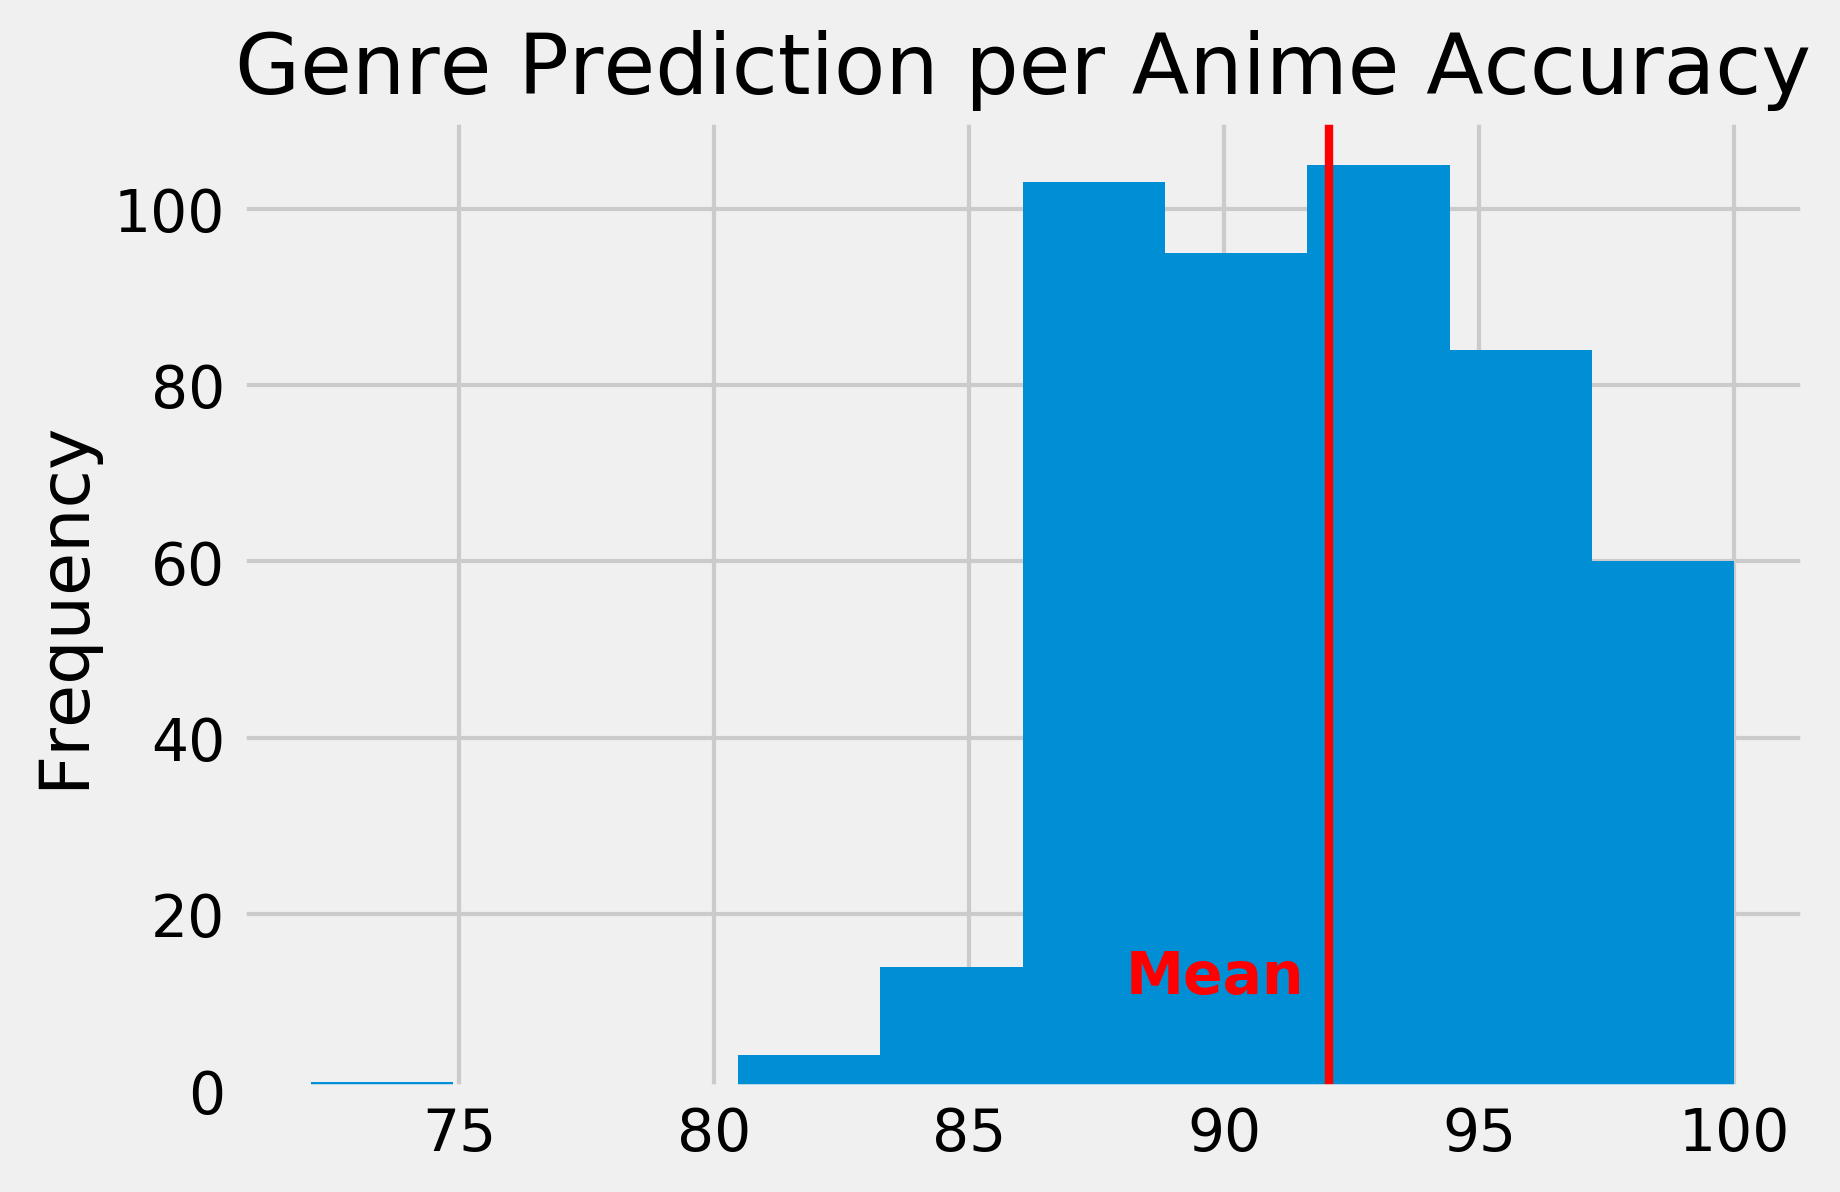

In [140]:
# Matplotlib configuration
mpl.rcParams['figure.dpi'] = 300    # tells matplotlib to display inline plots at 300 DPI
mpl.rc("savefig", dpi = 300)        # tells matplotlib to save plots at 300 DPI

# Building the histogram
graph = t["accuracy"].plot.hist(title = "Genre Prediction per Anime Accuracy")
mean = t["accuracy"].mean()
graph.axvline(mean, color = "red", linewidth = 2);    # Displays the red "Mean" vertical line. ';' prevents this line from displaying smth
graph.text(x = mean - 4, y = 11, s = "Mean", weight = 'bold', color = "red")    # Red "Mean" line legend

#### What do we learn from it?
* We note that almost 96% of animes had an accuracy value of 86% or more.
* We also see a small group of outliers having an accuracy below 75%.

In [141]:
# Code used to get precise values for our above observations
t["accuracy"].describe()
more_than_86_percentage = (t["accuracy"] > 86).sum() / len(t) * 100
print("We had an accuracy of 86% or more for " + str(round(more_than_86_percentage, 2)) + "% of animes")

count    466.000000
mean      92.060086
std        4.065484
min       72.093023
25%       88.372093
50%       93.023256
75%       95.348837
max      100.000000
Name: accuracy, dtype: float64

We had an accuracy of 86% or more for 95.92% of animes


#### Investigating outliers
There seems to be outliers having an accuracy below 75%. Let's investigate:

In [142]:
low_accuracy_animes = t[t["accuracy"] < 75]
low_accuracy_animes

,title,synopsis,genres,Shoujo,Harem,Slice of Life,Historical,Magic,Yuri,Mecha,Seinen,Ecchi,Super Power,Demons,Yaoi,Josei,Military,Horror,Police,Martial Arts,Comedy,Fantasy,Hentai,Sports,Shoujo Ai,...,Psychological_prediction,Psychological_prediction_is_accurate,Space_prediction,Space_prediction_is_accurate,Cars_prediction,Cars_prediction_is_accurate,Shounen Ai_prediction,Shounen Ai_prediction_is_accurate,Vampire_prediction,Vampire_prediction_is_accurate,Kids_prediction,Kids_prediction_is_accurate,Adventure_prediction,Adventure_prediction_is_accurate,Mystery_prediction,Mystery_prediction_is_accurate,Shounen_prediction,Shounen_prediction_is_accurate,Dementia_prediction,Dementia_prediction_is_accurate,Game_prediction,Game_prediction_is_accurate,Parody_prediction,Parody_prediction_is_accurate,accuracy
13,Nihon Animator Mihonichi,"[animator, mihonichi, collaborative, series, s...","[Action, Dementia, Ecchi, Fantasy, Mecha, Mili...",False,False,False,False,False,False,True,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,...,False,True,False,False,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,False,False,True,False,True,72.093023


There is only one anime that for which the genres are particularly hard to predict.
After looking [its page](https://myanimelist.net/anime/28149/Nihon_Animator_Mihonichi?q=nihon%20animator%20ni), we see that it seems to be a collection of shorts of various genres. Its synopsis is hard to link to all the genres features in the various shorts, so having difficulties predicting its genres is expected.

Its presence is not statistically significant enough for our analysis for us to drop it. We will just ignore it.

## Accuracy per genre
We will now assign an accuracy to each genre. This accuracy is defined by the percentage of animes for which the presence or absence of this particular genre was predicted accurately.

For example, with the genre A and 3 animes:

| | A is present | A was predicted as present | Prediction is correct
| --- | --- | --- | --- |
| Anime 1 | True | True | True
| Anime 2 | False | True | False
| Anime 3 | True | False | False
| Accuracy |   |   | $\frac{1}{3}= 33.3\%$ 

### Computing the accuracy per anime
For each anime, we will compute the accuracy, as well as its components, which are the percentages of:
* True positives
* False positives
* True negatives
* False negatives

In [143]:
# Returns a DataFrame associating each genre with its accuracy, true postives, false positives, true negatives, and false negatives
# Sorted by accuracy descending
def get_accuracy_per_genre_df(df):
    # We sum the boolean values for each column, selecting all the columns relative to a genre's prediction status
    predicted_col_names = [g + "_prediction_is_accurate" for g in selected_genres]
    accuracy_per_genre = (df[predicted_col_names].sum(axis = 0) / len(df)) * 100
    
    # Drilling down the successful and failed predictions: true postives, false positives, true negatives, and false negatives
    true_positive_proportions = []
    false_positive_proportions = []
    true_negative_proportions = []
    false_negative_proportions = []
    for genre in selected_genres:
        true_positive_proportions.append(((df[genre + "_prediction"] == True) & (df[genre] == True)).sum() / len(df) * 100)
        false_positive_proportions.append(((df[genre + "_prediction"] == True) & (df[genre] == False)).sum() / len(df) * 100)
        true_negative_proportions.append(((df[genre + "_prediction"] == False) & (df[genre] == False)).sum() / len(df) * 100)
        false_negative_proportions.append(((df[genre + "_prediction"] == False) & (df[genre] == True)).sum() / len(df) * 100)
    
    # Creating a DataFrame regrouping the data
    genre_stats = pd.DataFrame({
        "accuracy": list(accuracy_per_genre),
        "true_positive": true_positive_proportions,
        "false_positive": false_positive_proportions,
        "true_negative": true_negative_proportions,
        "false_negative": false_negative_proportions
    })
    genre_stats.index = selected_genres
     
    return genre_stats.sort_values("accuracy", ascending = False)

accuracy_per_genre_df = get_accuracy_per_genre_df(t)
accuracy_per_genre_df

,accuracy,true_positive,false_positive,true_negative,false_negative
Vampire,96.995708,0.429185,0.000000,96.566524,3.004292
Cars,96.781116,0.214592,0.000000,96.566524,3.218884
Space,96.566524,1.502146,0.214592,95.064378,3.218884
Kids,96.137339,1.931330,0.214592,94.206009,3.648069
Demons,96.137339,0.643777,0.214592,95.493562,3.648069
Josei,95.922747,0.214592,0.214592,95.708155,3.862661
Martial Arts,95.922747,0.000000,0.000000,95.922747,4.077253
Police,95.708155,0.858369,0.214592,94.849785,4.077253
Parody,95.708155,1.287554,0.429185,94.420601,3.862661
Dementia,95.708155,0.214592,0.000000,95.493562,4.291845


### Analyzing the accuracy values
We will start by focusing only on the accuracy value itself for now.

In [144]:
accuracy_per_genre_df["accuracy"].describe()

count    36.000000
mean     91.231521
std       6.241258
min      70.600858
25%      87.124464
50%      93.991416
75%      95.708155
max      96.995708
Name: accuracy, dtype: float64

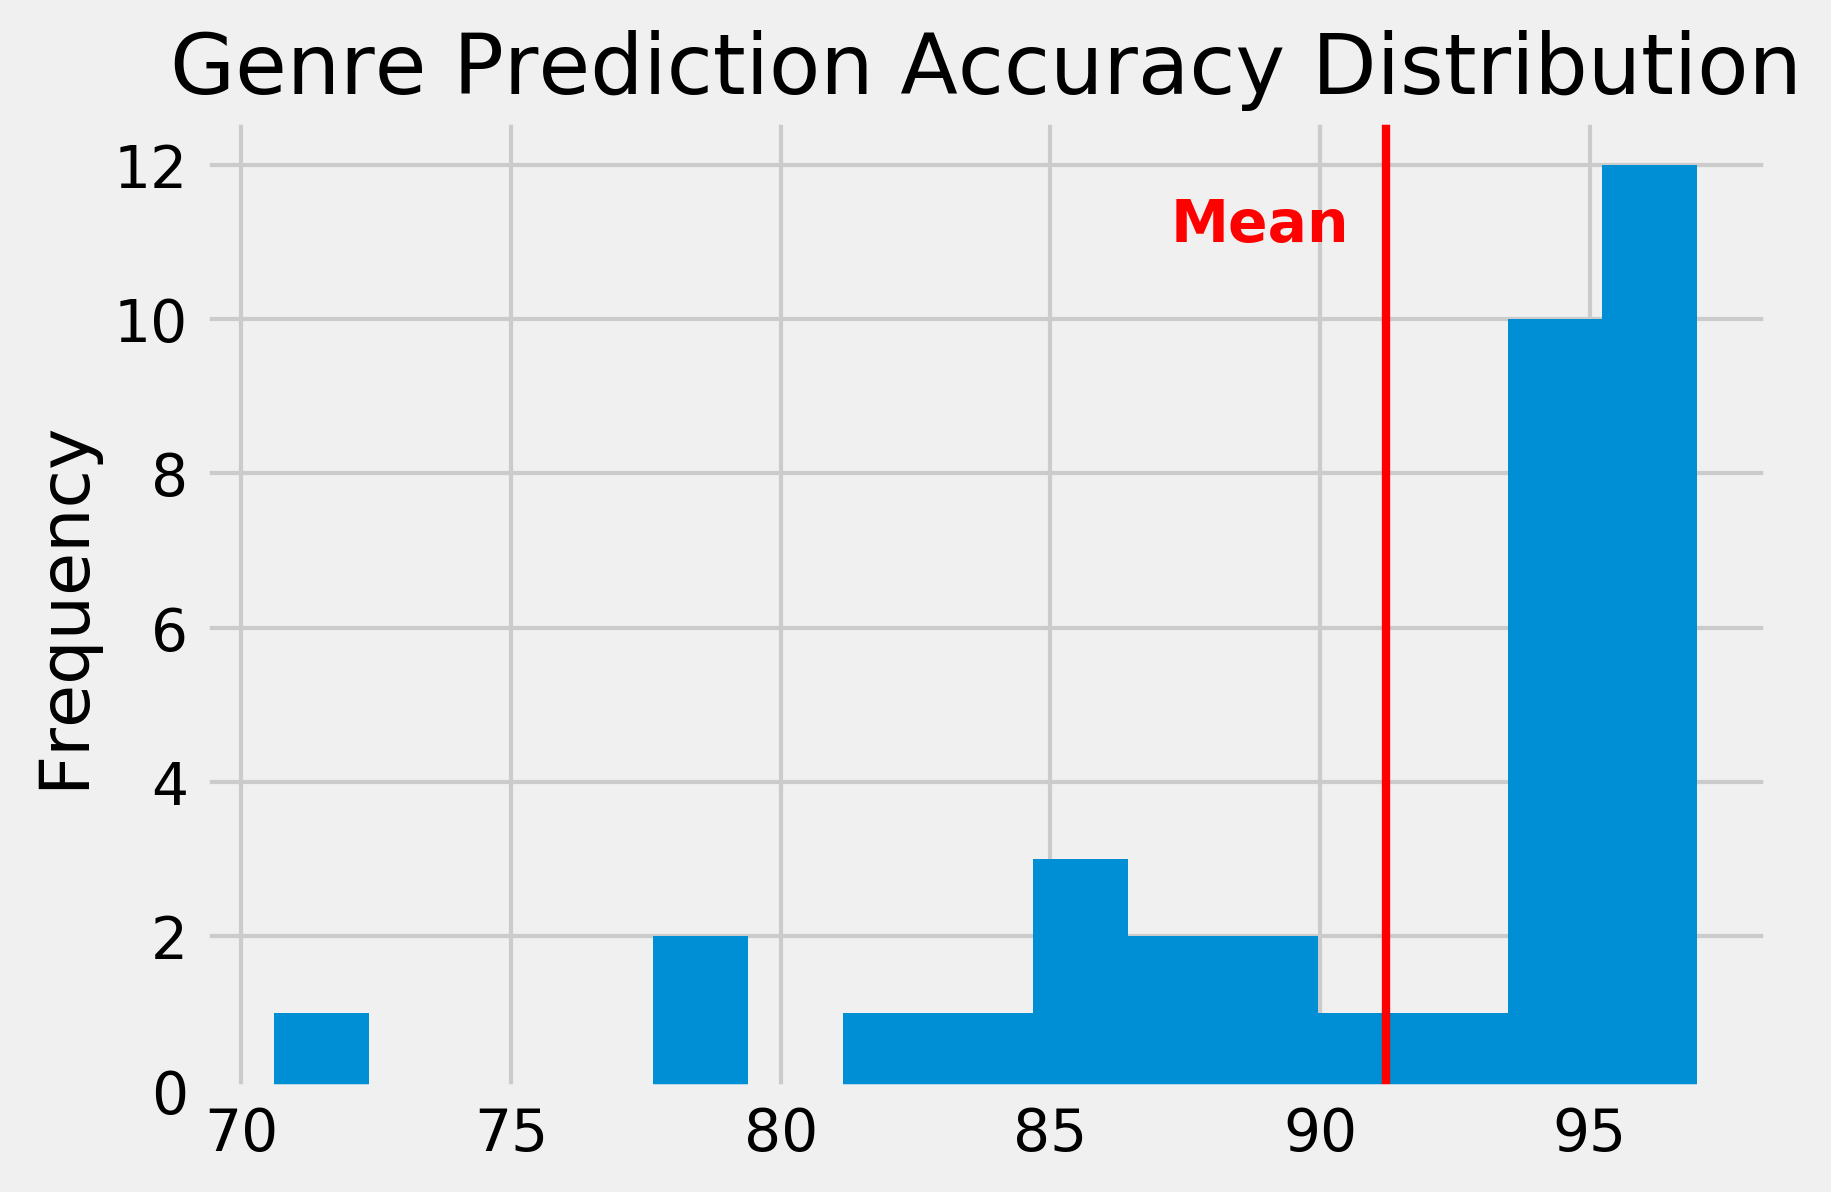

In [145]:
# Matplotlib configuration
mpl.rcParams['figure.dpi'] = 300    # tells matplotlib to display inline plots at 300 DPI
mpl.rc("savefig", dpi = 300)        # tells matplotlib to save plots at 300 DPI

# Building the histogram
graph = accuracy_per_genre_df["accuracy"].plot.hist(title = "Genre Prediction Accuracy Distribution", bins = 15)
mean = accuracy_per_genre_df["accuracy"].mean()
graph.axvline(mean, color = "red", linewidth = 2);    # Displays the red "Mean" vertical line. ';' prevents this line from displaying smth
graph.text(x = mean - 4, y = 11, s = "Mean", weight = 'bold', color = "red");    # Red "Mean" line legend

#### What do we learn from it?
* There is a higher spread of the values compared to the distribution of accuracies per anime (confirmed by having a higher standard deviation)
* Most of the values (75%) are above 87% accuracy
* The most common group of values, representing 50% of the values, are located at 94+%.
* We have a group of outliers at about [71%-72%] accuracy

Let's investigate this group of outliers:

In [146]:
outliers = accuracy_per_genre_df[accuracy_per_genre_df["accuracy"] < 74]
outliers

,accuracy,true_positive,false_positive,true_negative,false_negative
Comedy,70.600858,25.107296,11.802575,45.493562,17.596567


The only genre in this group is the genre "Comedy".

We can ask ourselves these questions:
* What are the details of our successes and failures? Are our failures mostly False Positives or False Negatives?
* In general, what makes a genre hard to predict?

### Success and failures details: true positives, false positives, true negatives and false negatives
To understand where our algorithm has the most trouble, we can look into these metrics.

#### Zooming on a genre's accuracy
The true positives, false positives, true negatives and false negatives values are a little bit hard to put into perspective.
Let's plot them as components of the success and failure percentages using a nested pie charts.

The code for this task is slightly long as:
* We have to generate two pie charts to have a nested pie chart
* We have to tweak many settings to make it readable and somewhat pretty
* As some values might be 0, we have to only show the non-zero values or it will make the chart odd and hard to understand

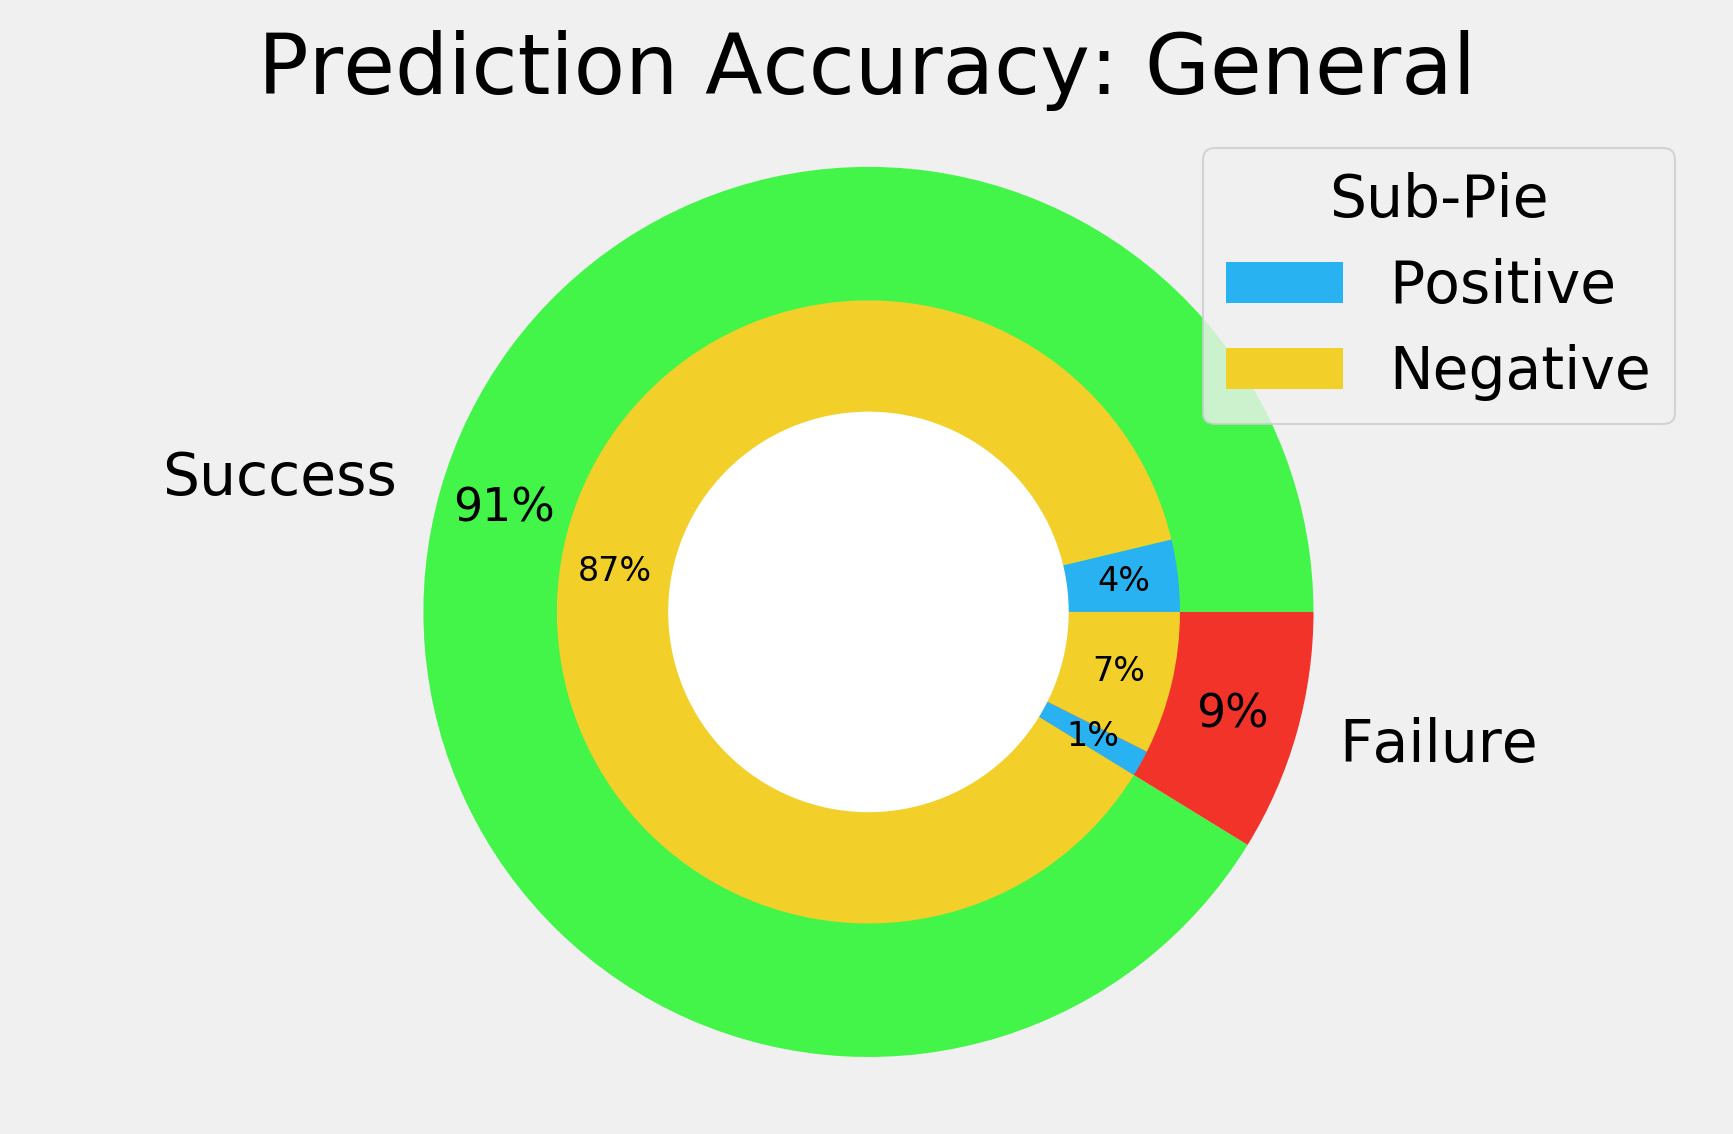

In [147]:
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300    # tells matplotlib to display inline plots at 300 DPI
mpl.rc("savefig", dpi = 300)        # tells matplotlib to save plots at 300 DPI
style.use("fivethirtyeight")

# Returns true if a word is in any of the strings in a list of strings
def word_in_list(word, list_of_strings):
    # we create an array of boolean values defined by wether or not the word is in each string
    # if we have at least one True in this list, it means that we found it at least once
    return True if True in [word in e for e in list_of_strings] else False

# Draw a nested pie chart describing the components of an accuracy.
# line_as_series = line of the accuracy df. Could be a generated line (mean line)
def accuracy_pie(line_as_series):    
    color_h = {"green": "#42f548", "red": "#f23329", "cyan": "#29b2f2", "yellow": "#f2d029"}
    
    # Main pie data: Success proportion vs Failure proportion
    labels = ["Success", "Failure"]
    sizes = [line_as_series.accuracy, 100 - line_as_series.accuracy]
    colors = [color_h["green"], color_h["red"]]
    
    # Sub-pie data: True Positive proportion, True Negative proportion, False Positive Proportion, False Negative proportion
    sub_labels = ["True Positive", "True Negative", "False Positive", "False Negative"]
    sub_sizes = [line_as_series.true_positive, line_as_series.true_negative,
                    line_as_series.false_positive, line_as_series.false_negative]
    sub_colors = [color_h["cyan"], color_h["yellow"], color_h["cyan"], color_h["yellow"]]
    # Among the 4 items, we only display those which will render as at least .5%, otherwise it renders a useless 0%
    labels_subpie = []
    sizes_subpie = []
    colors_subpie = []
    item_data = {}
    for i in range(4):
        if sub_sizes[i] > 0.49:
            labels_subpie.append(sub_labels[i])
            sizes_subpie.append(sub_sizes[i])
            colors_subpie.append(sub_colors[i])
      
    # Title
    # If the name attribute is empty, it means that the plot is on general accuracy. Otherwise it's on a particual genre
    accuracy_type = line_as_series.name if line_as_series.name != None else "General" 
    title = "Prediction Accuracy: " + accuracy_type
    
    # Plot
    wedges, labels, autopct = plt.pie(sizes, labels=labels, colors=colors, startangle=0,frame=True,    # outer plot
                                      autopct='%1.0f%%', pctdistance=0.85)
    plt.setp(autopct, fontsize=11)
    
    wedges, labels, autopct = plt.pie(sizes_subpie, colors=colors_subpie,radius=0.7,startangle=0,    # innter plot
                                      autopct='%1.0f%%', pctdistance=0.825, labeldistance = .4)
    plt.setp(labels, fontsize=6)
    plt.setp(autopct, fontsize=8)
    
    # Adding legend for the subpie [Positive [color] Negative [color]]
    # We only keep the legends for which we have a representation in the plot
    subpie_legend_labels = [word for word in ["Positive", "Negative"] if word_in_list(word, labels_subpie)]
    plt.legend(wedges[:len(subpie_legend_labels)], subpie_legend_labels, title = "Sub-Pie")
    
    # Drawing a circle in the middle
    centre_circle = plt.Circle((0, 0), 0.45, color = 'black', fc = 'white', linewidth = 0)
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    
    plt.title(title)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()    

mean_line = accuracy_per_genre_df.mean()    # Series containing the mean for the accuracy and its components
accuracy_pie(mean_line)                     # Plotting the General Accuracy

##### How to read it?
This chart about our general accuracy per genre tells us that, on average:
* We predict accurately 91% of the presence/absence of a genre, so we fail 9% of the time
* 4%  of the time our prediction is a true positive:  we predicted the genre as present and it is (blue component of success)
* 87% of the time our prediction is a true negative:  we predicted the genre as absent and it is (yellow component of success)
* 1%  of the time our prediction is a false positive: we predicted the genre as present but it is not (blue component of failure)
* 7%  of the time our prediction is a false negative: we predicted the genre as absent but it is present (yellow component of failure)

These values are rounded so the sum might not always be 100%.

#### What to we learn from it?
* We have a satisfactory average accuracy per genre: 91%
* On average, most of the accuracy value relative to a genre is due to its common absence. It makes sense as there are 43 unique genres and only an average of about 4.4 genres present per anime. By default, odds are that an arbitrary genre is absent from an arbitrary anime. Our algorithm has indirectly learned this concept so gets most of its accuracy value by correctly assessing the absence of genres.
* Most of our failures (84% of them) are due to our algorithm defaulting to assessing a genre as absent, even when it sometimes is actually present. It makes sense because of the previous point.

In [148]:
# Code used to get some values for the above explanations
mean_line
average_n_genres = training_set_clean["genres"].apply(len).mean()    # Average amount of present genres per anime
average_n_genres

accuracy          91.231521
true_positive      3.737482
false_positive     1.365045
true_negative     87.494039
false_negative     7.403433
dtype: float64

4.3587131367292224

#### But what about a specific genre?
We will now look at two genres case by case:
* The genre with the highest accuracy
* The genre with the lowest accuracy

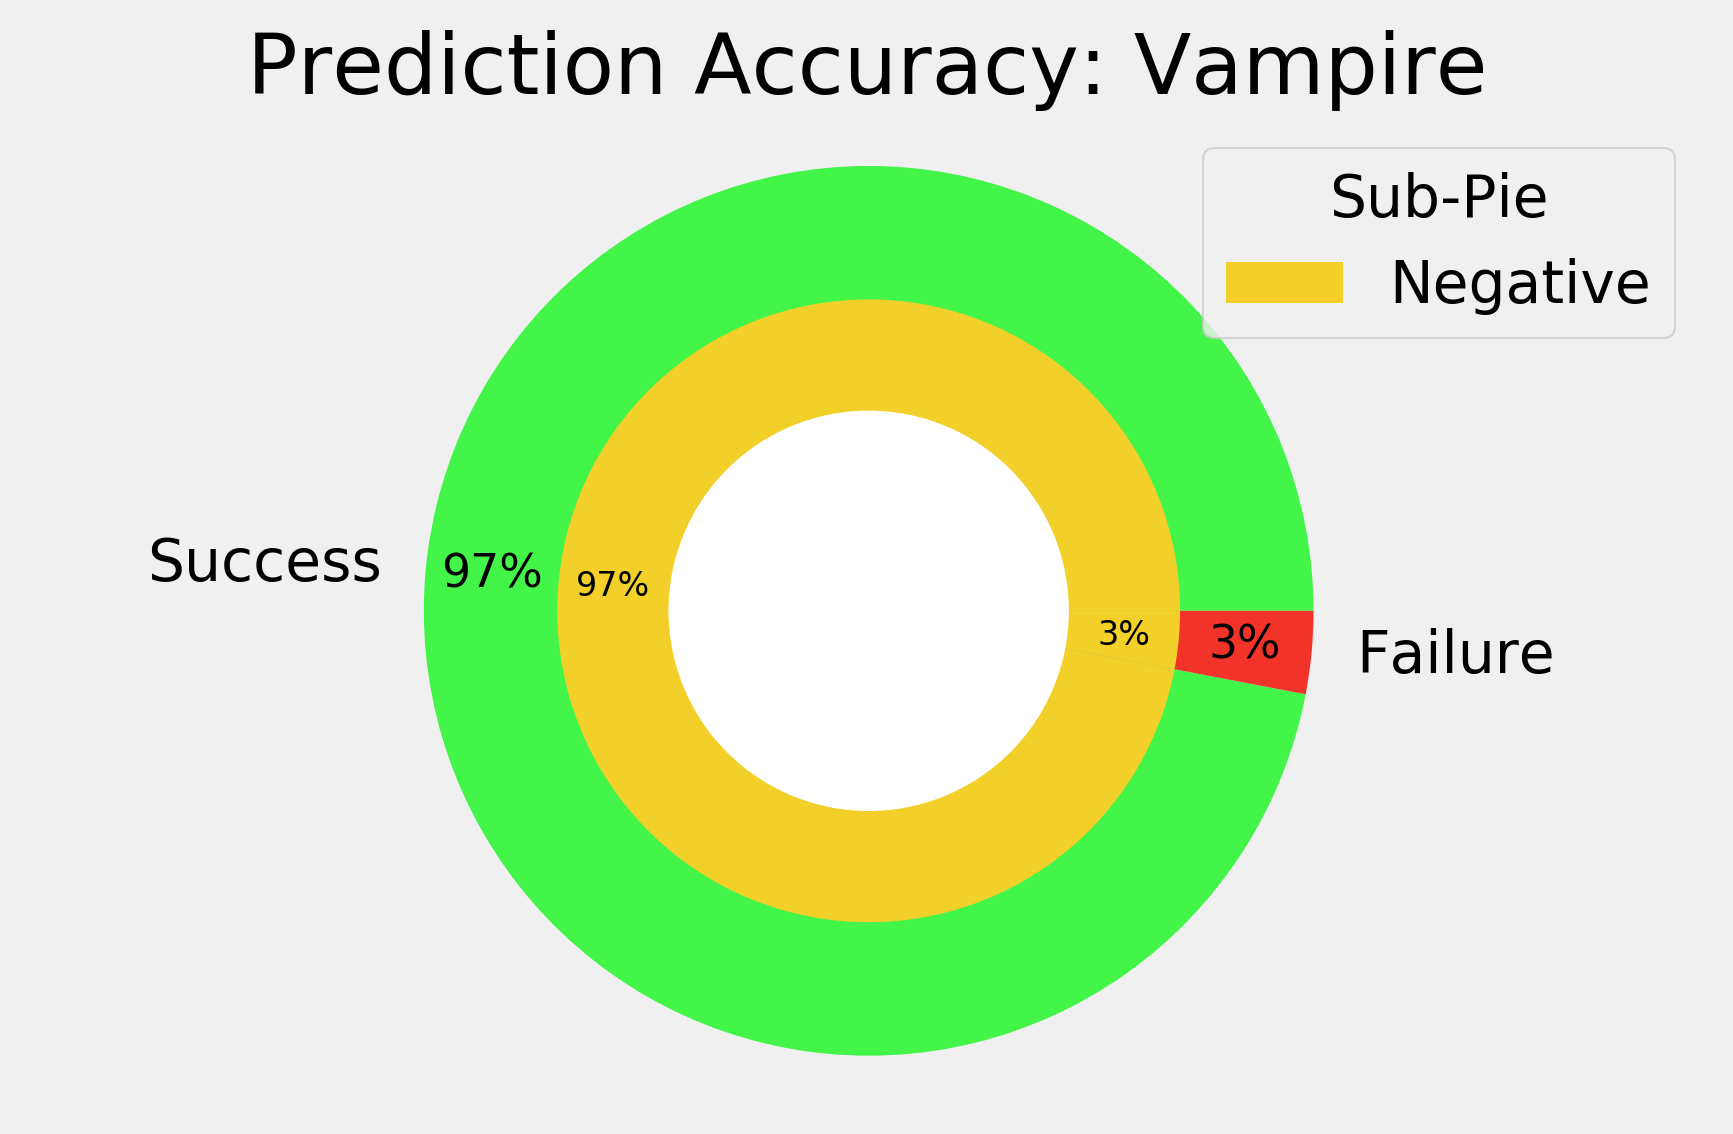

In [149]:
accuracy_pie(accuracy_per_genre_df.iloc[0])    # Highest accuracy genre

#### What do we learn from it?
For the easiest genre to predict:
* Our algorithm predicted the absence of the genre in 100% of cases
* By doing so, he got 97% true negatives and 3% false negatives

Using the code below, we learn that, in the training set, there were only 85 animes of this genre (4.6%). It is therefore not surprising that our algorithm could not learn enough about this genre to have true positives.

In [150]:
# Code used to get values for the above explanations
highest_accuracy_genre = accuracy_per_genre_df.iloc[0].name
amount_in_training_set = training_set_clean[highest_accuracy_genre].sum()
percentage_in_training_set = amount_in_training_set / len(training_set_clean) * 100
amount_in_training_set
percentage_in_training_set

85

4.557640750670242

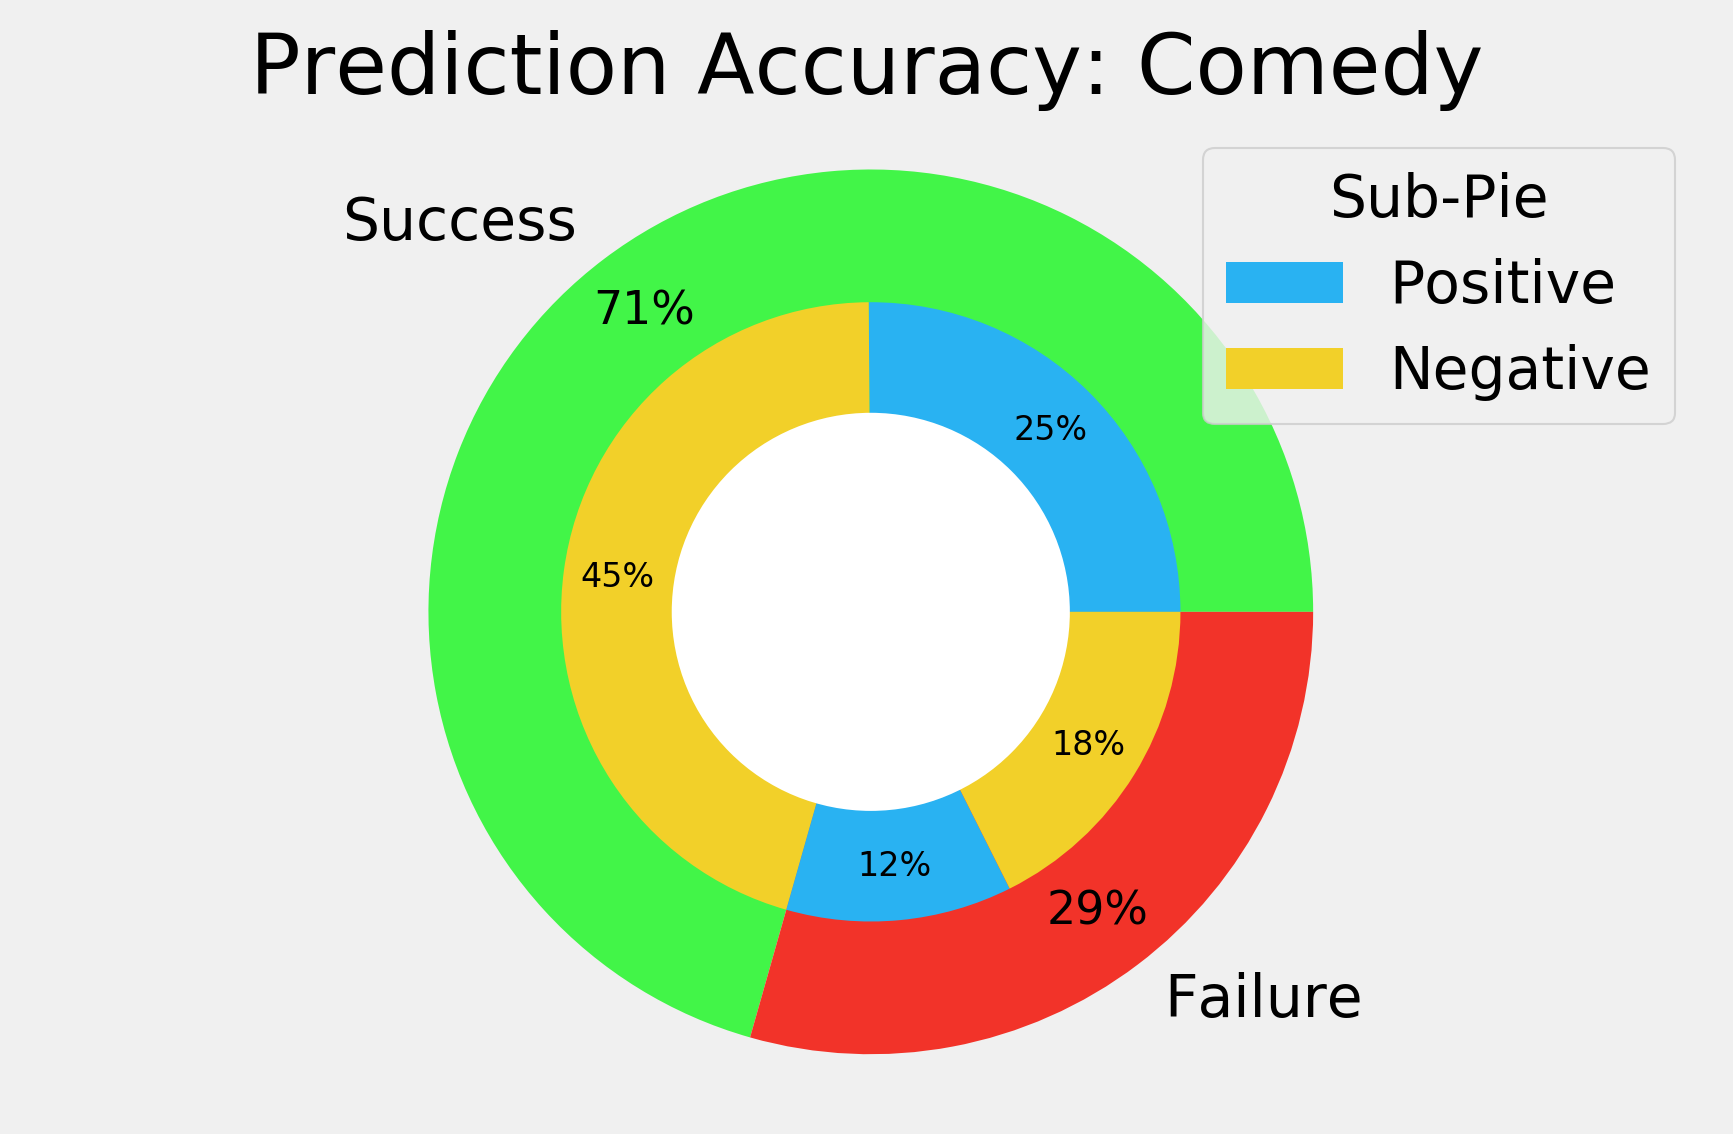

In [151]:
accuracy_pie(accuracy_per_genre_df.iloc[-1])   # Lowest accuracy genre

#### What do we learn from it?
For the hardest genre to predict:
* The positives and negatives are way more equally distributed than on the previous charts, but we still see a dominance of the negatives.
* Out of our 4 components of accuracy, none seems to be left out: our algorithm succeeds and fails in every way. It might mean that this genre had enough representatives for our algorithm but still did not have distinctive enough words for our algorithm to learn from well and be able to identify it consistently.

With some domain knowledge, we note that the highest accuracy genre is quite rare, whereas the lowest accuracy genre is very common. Could there be a link between the popularity of a genre and its difficulty of prediction?

## What makes a genre easy to predict? Looking for correlations
We suspect a link between the popularity of a genre and its difficulty of prediction. Let's explore this link and try to find others.

### Visualizing the distribution of genres
To explore this first link, we need to have an overview the popularity of our genres:

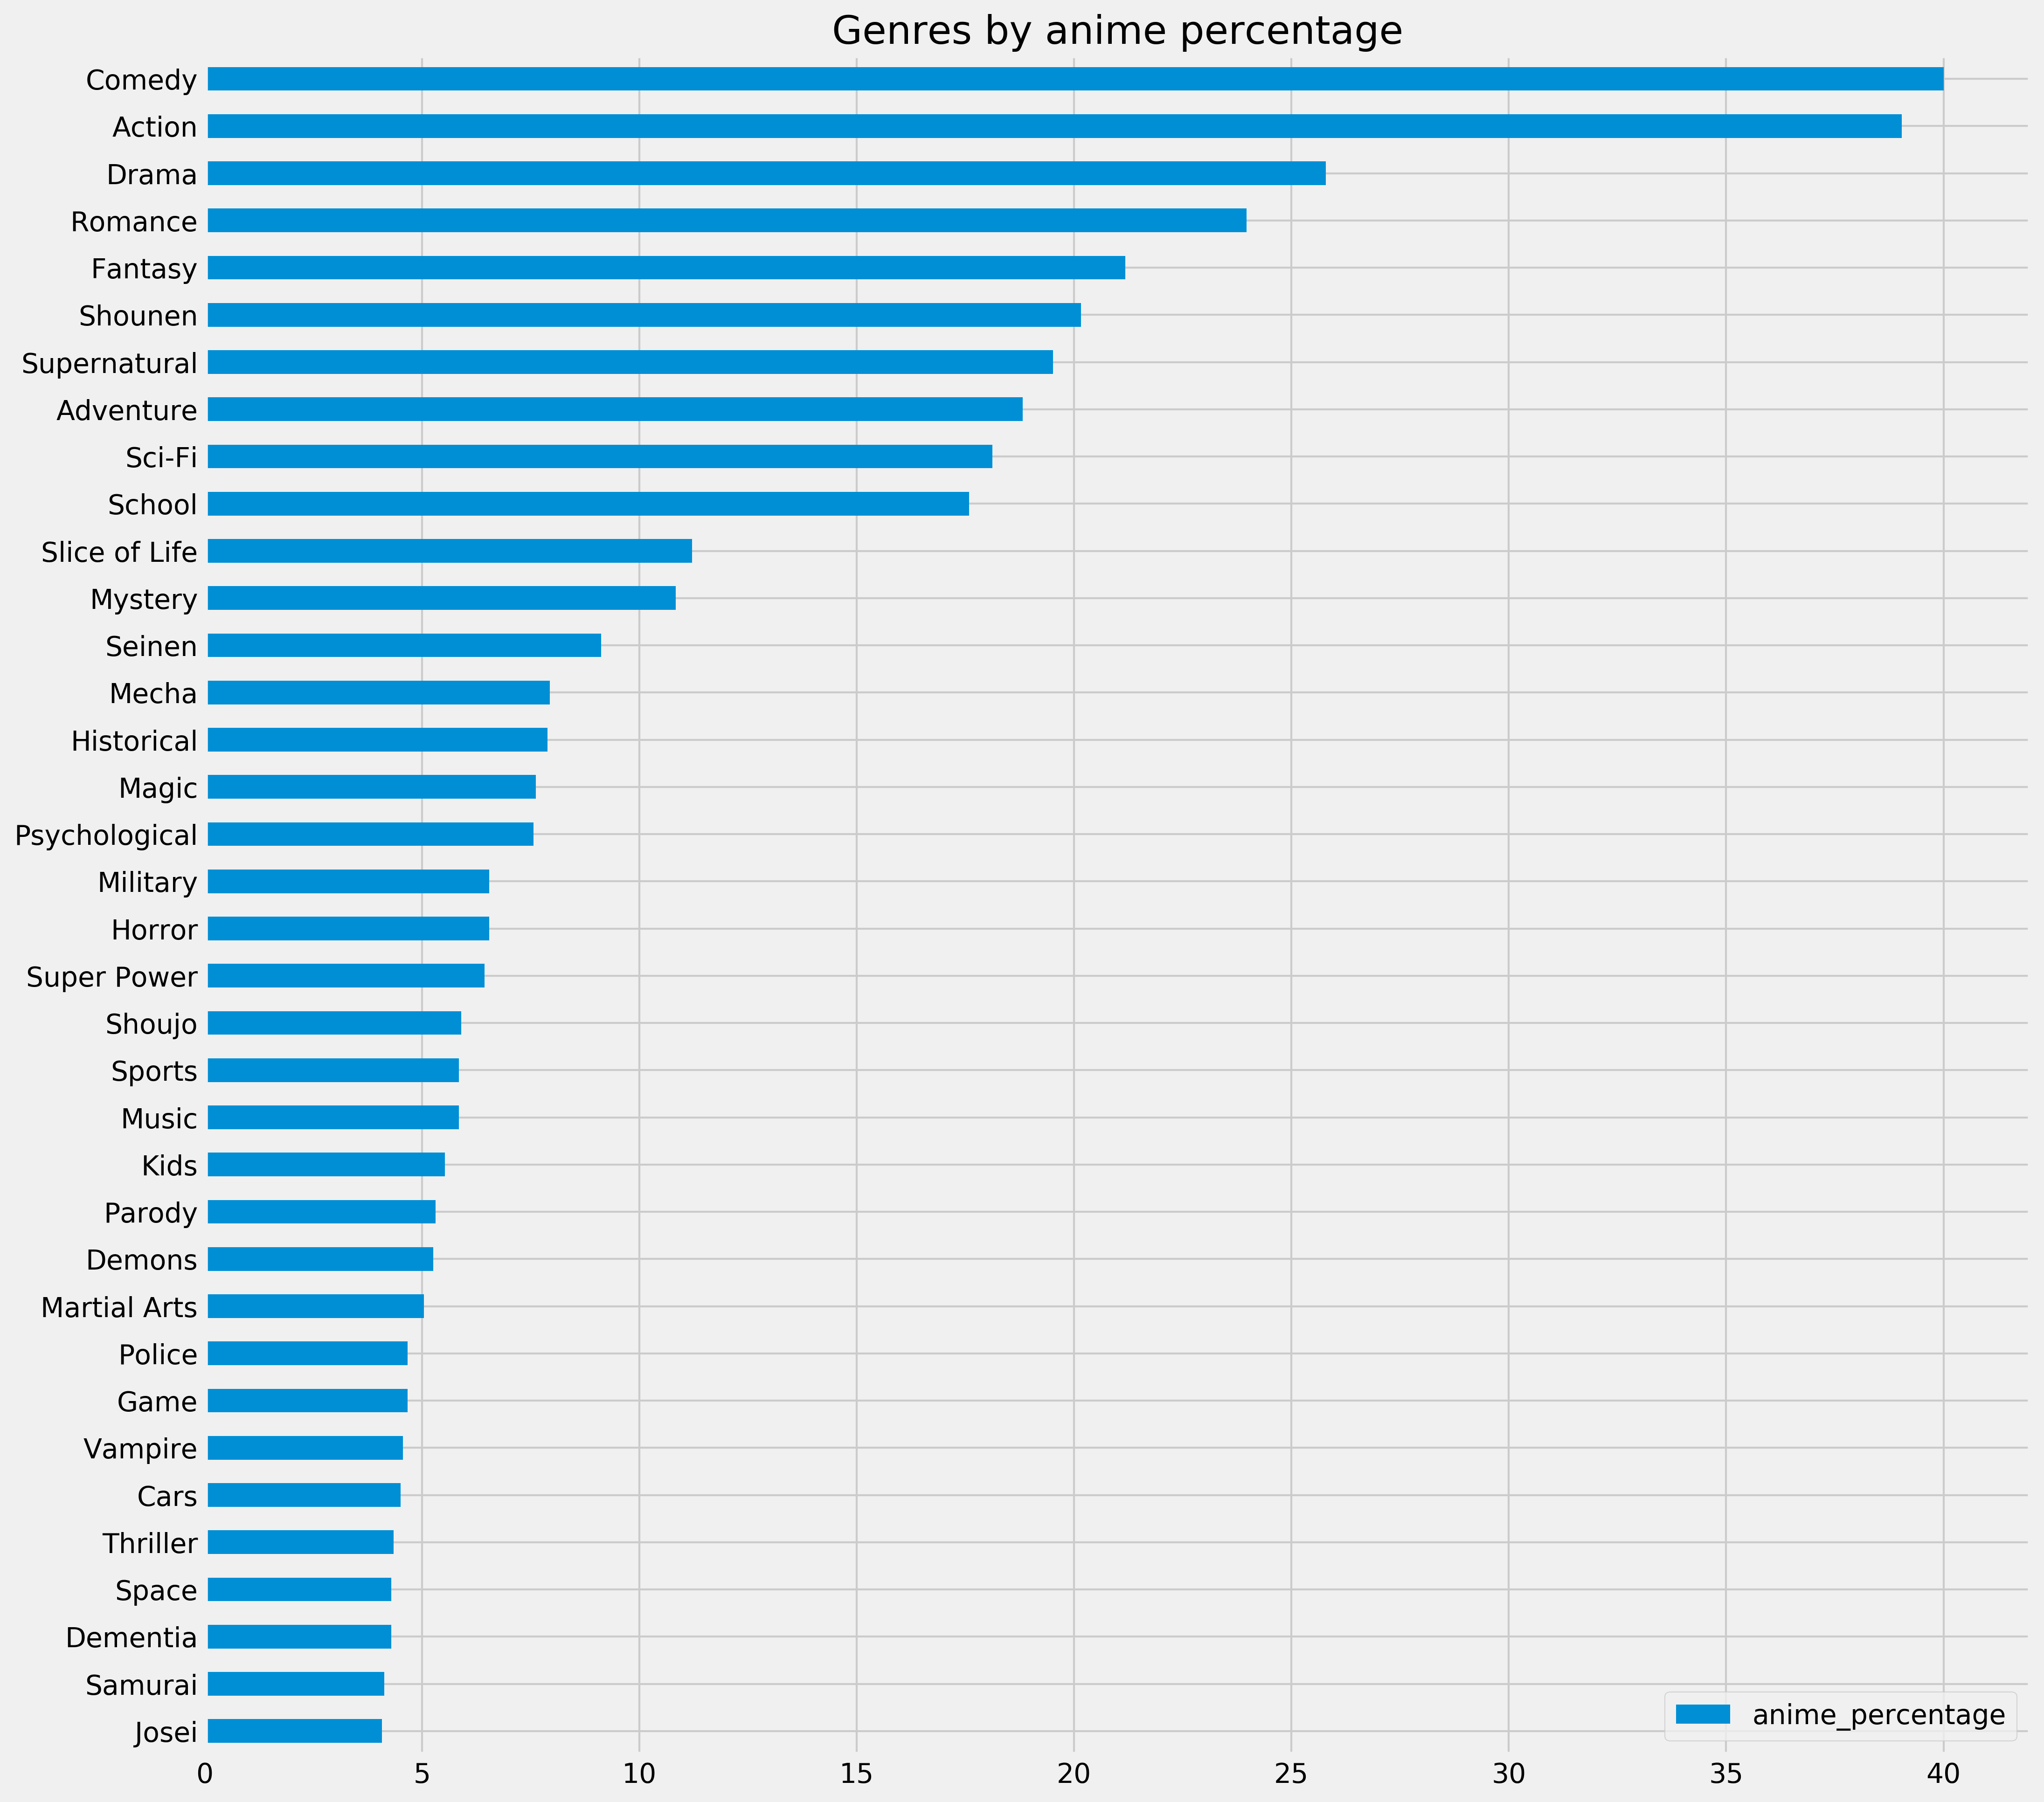

In [152]:
# We already computed these genre percentages (genre_p) when computing constants of our Naive Bayes algorithm
genre_distribution = pd.Series(genre_p, name = "anime_percentage") * 100
# We then exclude NSFW genres if necessary, sort our values by popularity, and plot them in a horizontal bar plot
genre_distribution.loc[selected_genres].sort_values().plot.barh(figsize=(15, 15), title="Genres by anime percentage", legend=True)

#### What do we learn from it?
* The Comedy genre is indeed popular. In fact, it is the most popular with 40% of animes being of this genre.
* The Vampire genre is indeed unpopular. It is 7th least popular genre with about 4.5% popularity.
* Most genres are unpopular, with $\frac{2}{3}$ of them being under 10% popularity.

Now that we have a better overview of our genres' popularity, let's explore potential correlations.

### Looking for correlations
What makes a genre easy or hard to predict?
We suspect that the popularity of a genre makes it hard to predict as the most popular anime had to worst accuracy, whereas the anime with the highest accuracy was quite unpopular.

We will explore the potential correlations between:
* The accuracy of a genre and its popularity
* The accuracy of a genre and its average number of words in its synopsis

In [153]:
# Creating a DataFrame containing, for each genre, its accuracy and popularity.
corr_df = pd.concat([accuracy_per_genre_df["accuracy"], pd.Series(genre_p, name="percentage of total")*100], axis=1, sort=False)
# To this DataFrame we add the average word per synopsis column
corr_df["avg_words_per_synopsis"] = corr_df.apply(lambda row: genre_n_words[row.name] / training_set_clean[row.name].sum(), axis=1)

# removing nsfw genres in necessary
if not Constants.INCLUDE_NSFW_GENRES:
    corr_df = corr_df[:-(len(genres) - len(genres_sfw))]
    
corr_df

,accuracy,percentage of total,avg_words_per_synopsis
Vampire,96.995708,4.557641,34.576471
Cars,96.781116,4.504021,19.511905
Space,96.566524,4.289544,48.450000
Kids,96.137339,5.522788,35.271845
Demons,96.137339,5.254692,39.500000
Josei,95.922747,4.075067,30.605263
Martial Arts,95.922747,5.040214,36.510638
Police,95.708155,4.664879,39.701149
Parody,95.708155,5.308311,34.858586
Dementia,95.708155,4.289544,21.437500


In [154]:
corr_df.corr()   # Directly generates a correlation matrix for us (using the standard correlation coefficient)

,accuracy,percentage of total,avg_words_per_synopsis
accuracy,1.000000,-0.971383,-0.346985
percentage of total,-0.971383,1.000000,0.337123
avg_words_per_synopsis,-0.346985,0.337123,1.000000


### Observations
* The correlation between the accuracy of a genre and the percentage of animes of this genre is almost perfectly negative (-0.97). Our suspicions seem correct: the more common the genre, the harder it is to predict.
* There isn't a significant correlation between the accuracy of a genre and its average number of words per synopsis. There is a sleight negative correlation, implying that the lengthier the synopsis, the harder it is to predict, but it's weak (-0.35).

## Are genres linked?
Do certain combinations of genres appear more frequently than others?

We can explore this question by looking at the linear correlations between the presence of a genre and another.

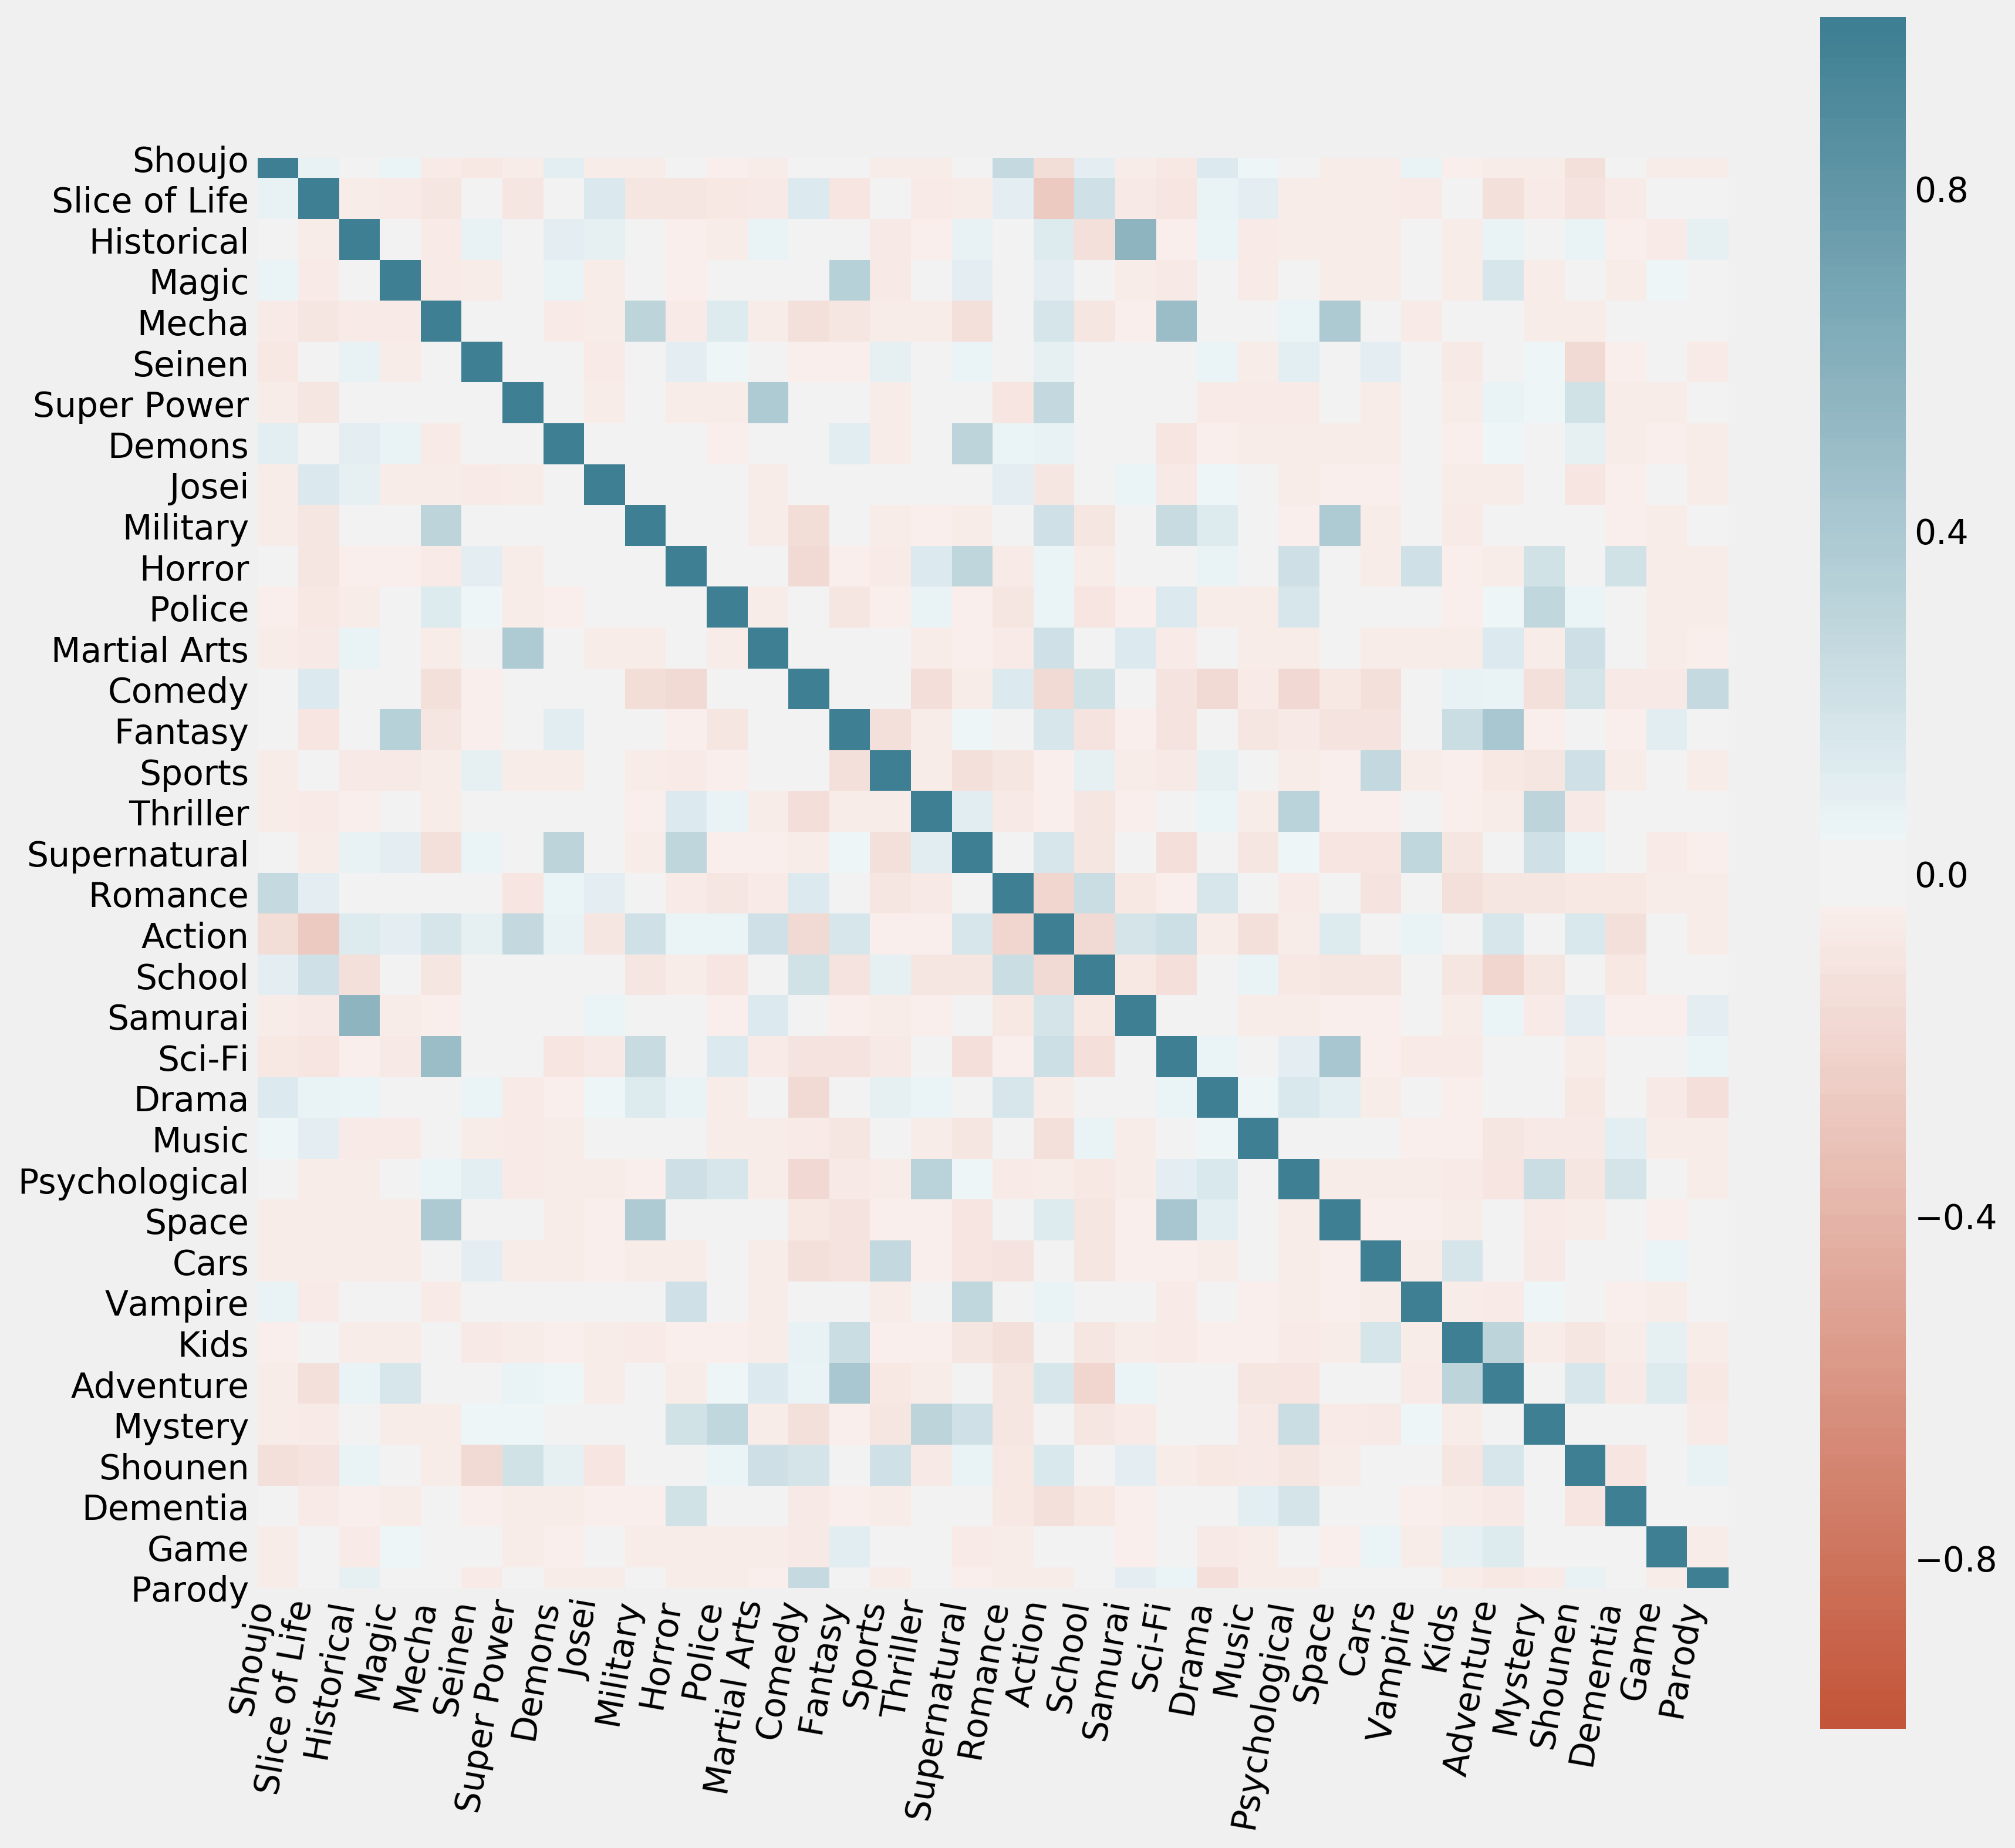

In [155]:
import seaborn as sns    # more plot tools

# Matplotlib configuration
mpl.rcParams['figure.dpi'] = 300    # tells matplotlib to display inline plots at 300 DPI
mpl.rc("savefig", dpi = 300)        # tells matplotlib to save plots at 300 DPI

# Plots a heatmap of correlations
def corr_heatmap(corr_data, figsize):
    f, ax = plt.subplots(figsize=figsize)
    ax = sns.heatmap(
        corr_data, 
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=80,
        horizontalalignment='right'
    );

# We select the genre columns from our training set, and compute correlations
# Our genre columns already contain boolean values indicating the presence or absence of this genre
corr = training_set_clean[selected_genres].corr()
corr_heatmap(corr, (12, 12))

### Observations
* We don't see any obviously strong correlations

Let's try to extract genres for which the correlation is above a certain threshold:

In [156]:
# Isolates the genres for which we have a significant correlation (> abs_threshold or < -abs_threshold)
def select_significant_corrs(df, abs_threshold):
    df = df.copy()
    
    # Sets correlations to 0 for correlations not respecting the threshold
    for genre in selected_genres:
        df[genre] = df[genre].apply(lambda c: 0 if -abs_threshold < c < abs_threshold else c)
    
    # Selects only genres that have at least one significant correlation with another genre
    relevant_genres = [genre for genre in selected_genres if df.loc[genre].sum() > 1]    # 1 as we also have the correlation with itself

    return df.loc[relevant_genres][relevant_genres]

#### Moderate correlations

In [157]:
moderate_correlations = select_significant_corrs(corr, .5)
moderate_correlations

,Historical,Samurai
Historical,1.000000,0.559411
Samurai,0.559411,1.000000


Out of all the combinations of genres, only one has a moderate or better correlation, which is surprising.
The combination Samurai + Historical makes a lot of sense as we can imagine the strong relationship between these two genres. Samurai probably causes Historical. 

#### Weak correlations

,Historical,Magic,Mecha,Super Power,Demons,Military,Martial Arts,Fantasy,Thriller,Supernatural,Samurai,Sci-Fi,Psychological,Space,Kids,Adventure,Mystery
Historical,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.559411,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Magic,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.331148,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Mecha,0.000000,0.000000,1.000000,0.000000,0.000000,0.307427,0.000000,0.000000,0.000000,0.000000,0.000000,0.490139,0.000000,0.397993,0.000000,0.000000,0.000000
Super Power,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.379096,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Demons,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.308456,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Military,0.000000,0.000000,0.307427,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.382794,0.000000,0.000000,0.000000
Martial Arts,0.000000,0.000000,0.000000,0.379096,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Fantasy,0.000000,0.331148,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.411819,0.000000
Thriller,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.327146,0.000000,0.000000,0.000000,0.306653
Supernatural,0.000000,0.000000,0.000000,0.000000,0.308456,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


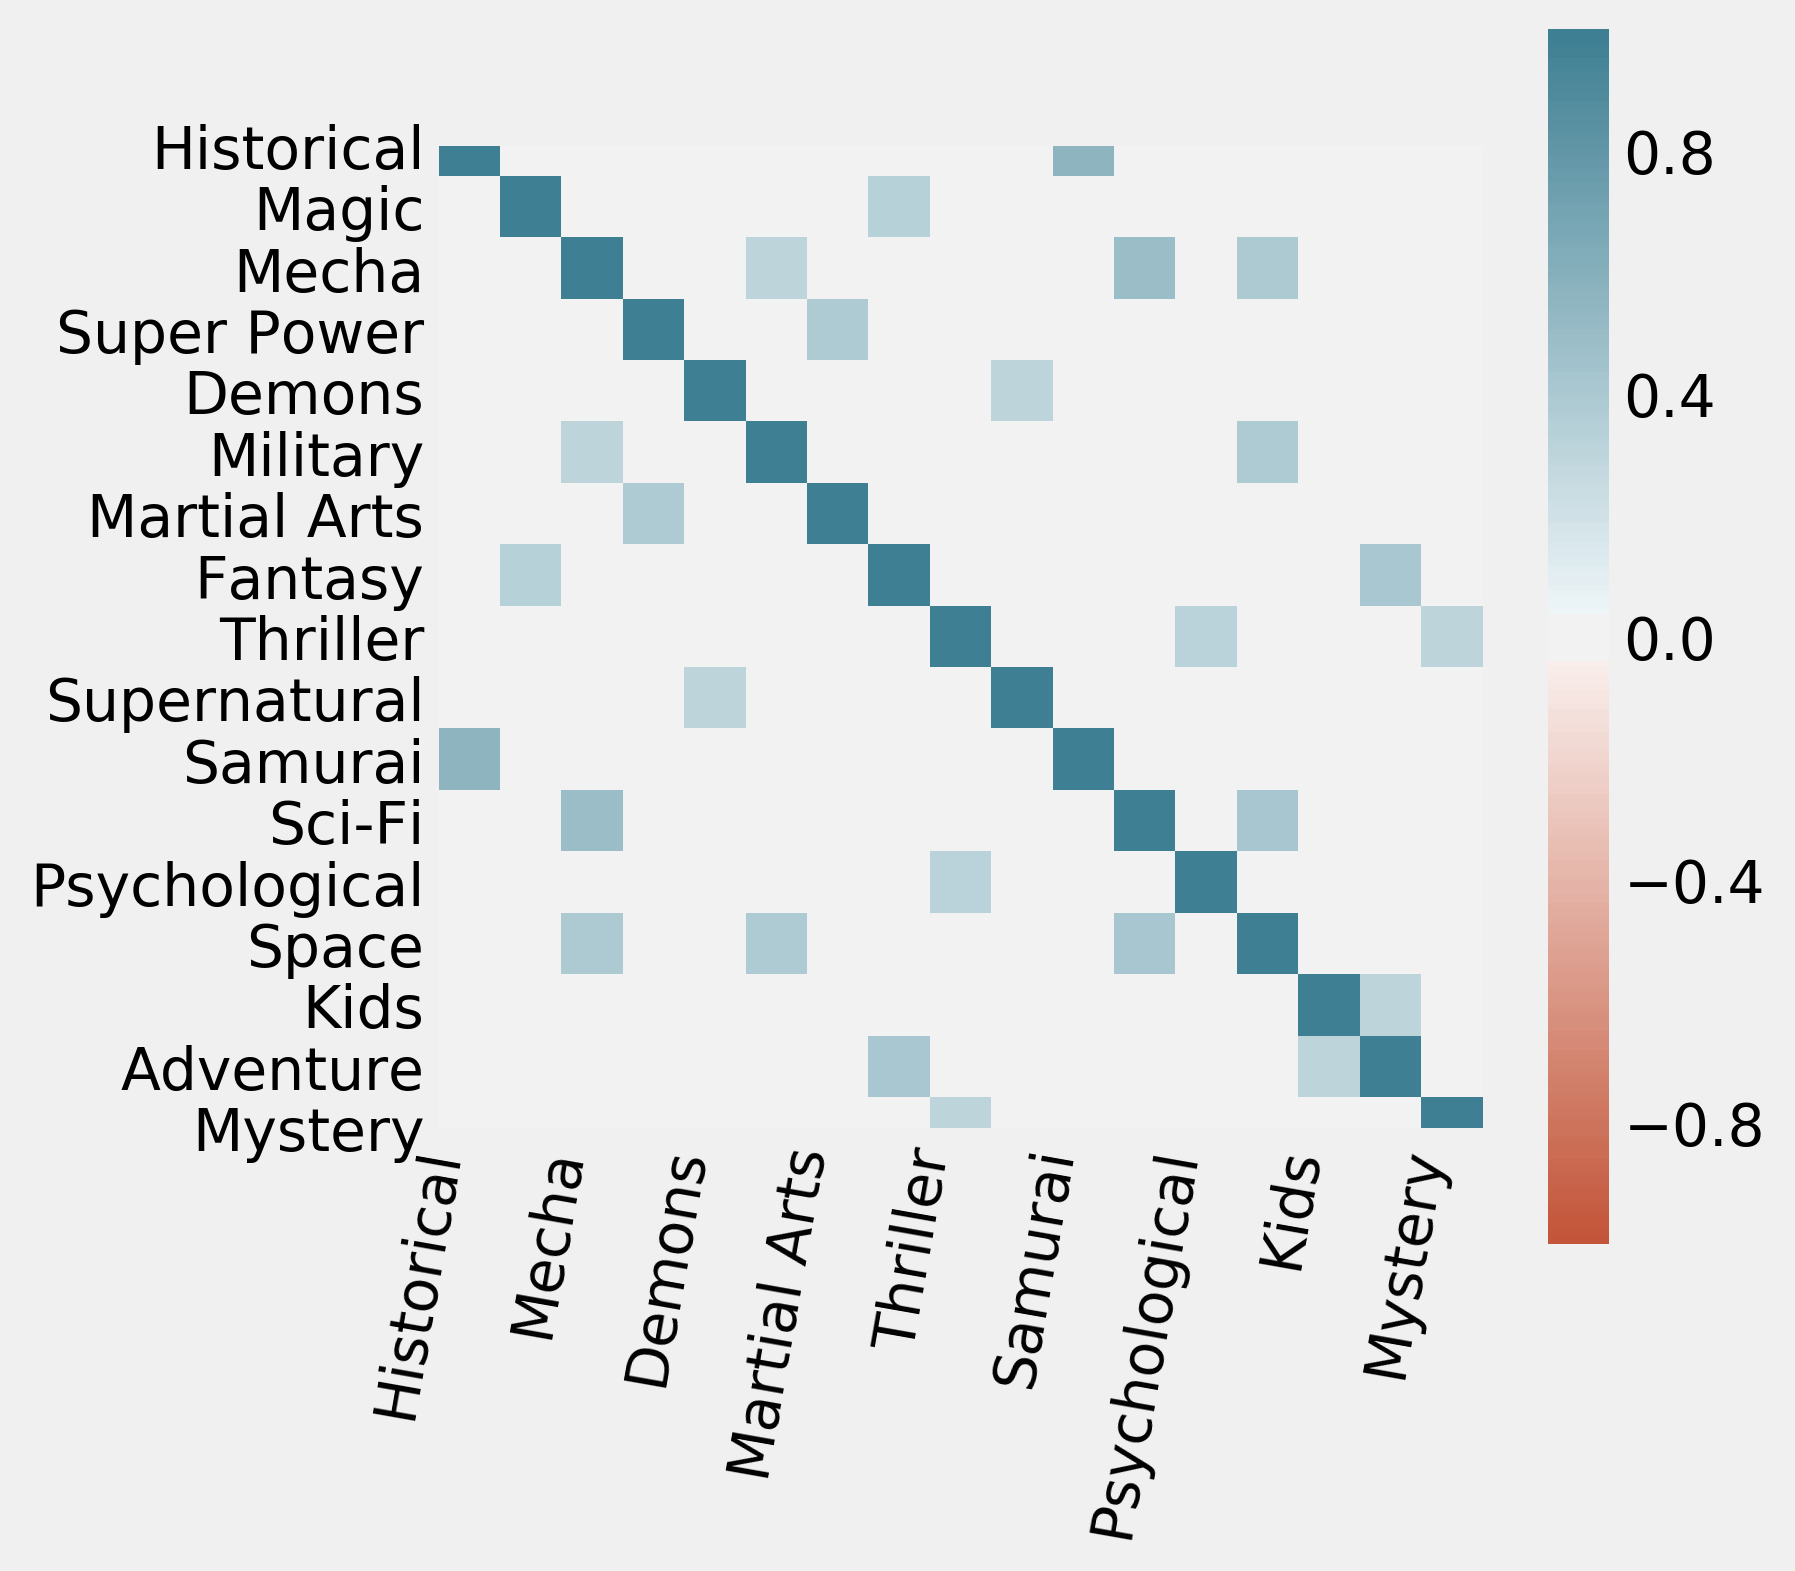

In [158]:
weak_correlations = select_significant_corrs(corr, .3)
weak_correlations
corr_heatmap(weak_correlations, (5, 5))

#### Observations
* There are many weak correlations ($\frac{17}{36} = 47\%$). About half of the genres are linked to at least one other genre.
* They seem to make a lot of sense. Examples: [Sci-Fi + Space], [Mecha + Space], [Fantasy + Adventure], [Supernatural + Demons]... It is surprising that these correlations are only weak.
* Some of them form common combinations of more than 2 genres: [Sci-Fi + Space + Mecha] seems common.
* There are no significant negative correlations. It means that no genre consistently excludes another: any combination is possible.

## Visualizing the most significant words per genre
It could be interesting to see which words weigh the most when deciding if an anime is of a given genre or not.

We will measure the weight of a word as being its lift. The lift of a word measures by how much the probability of being of a genre increases or decreases (factor) when the word is added to the synopsis.

### Counting repeats in a single synopsis as only one occurrence
Some words can get a high lift because they are repeated several times in a single synopsis, counting as if the word was present in several distinct synopsis of this genre.

In [159]:
# We start by computing the amount of animes that feature at least once each word
# It removes the bias for words with multiple repeats per synopsis
def get_word_occurences_singleton():
    output_df = pd.DataFrame(columns = [])
    for w in vocabulary:
        output_df[w] = training_set_clean[w].apply(lambda n: False if n == 0 else True)
    return output_df.sum().rename("occurences_singleton")

word_occurences_singleton = get_word_occurences_singleton()

### Plotting the most significant words of a genre
In this function we will:
* Compute the lift of each word relative to the given genre
* Exclude words that appear rarely for animes of this genre
* Plot the 15 words with the highest lift with a horizontal bar plot

We define the lift of a word relative to a genre as being the difference between the "probability" of this word to be of the genre and to not be of this genre divided by the "probability" of it not being of this genre.

In [160]:
def plot_best_words_of_genre(g):
    # Creating a DataFrame allowing us to compute the lift of words
    genre_words = pd.Series(parameters[g], name = "p_word_given_" + g)
    not_genre_words = pd.Series(parameters_no[g], name = "p_word_given_not_" + g)
    genre_words_df = pd.concat([genre_words, not_genre_words, word_occurences_singleton], axis = 1, sort = False)
    genre_words_df["lift"] = (genre_words_df["p_word_given_" + g] - genre_words_df["p_word_given_not_" + g]) / genre_words_df["p_word_given_not_" + g]
    
    # Excluding words that appear in less than 1% of animes of this genre
    min_occurences = training_set_clean[g].sum() * .01
    common_words = genre_words_df[genre_words_df["occurences_singleton"] >= min_occurences]
    
    # Horizontal bar plot of the 15 words with the highest lift
    common_words.sort_values(by = "lift", ascending = False).head(15).sort_values("lift")[["lift"]].plot.barh(title = "Most significant " + g + " words")

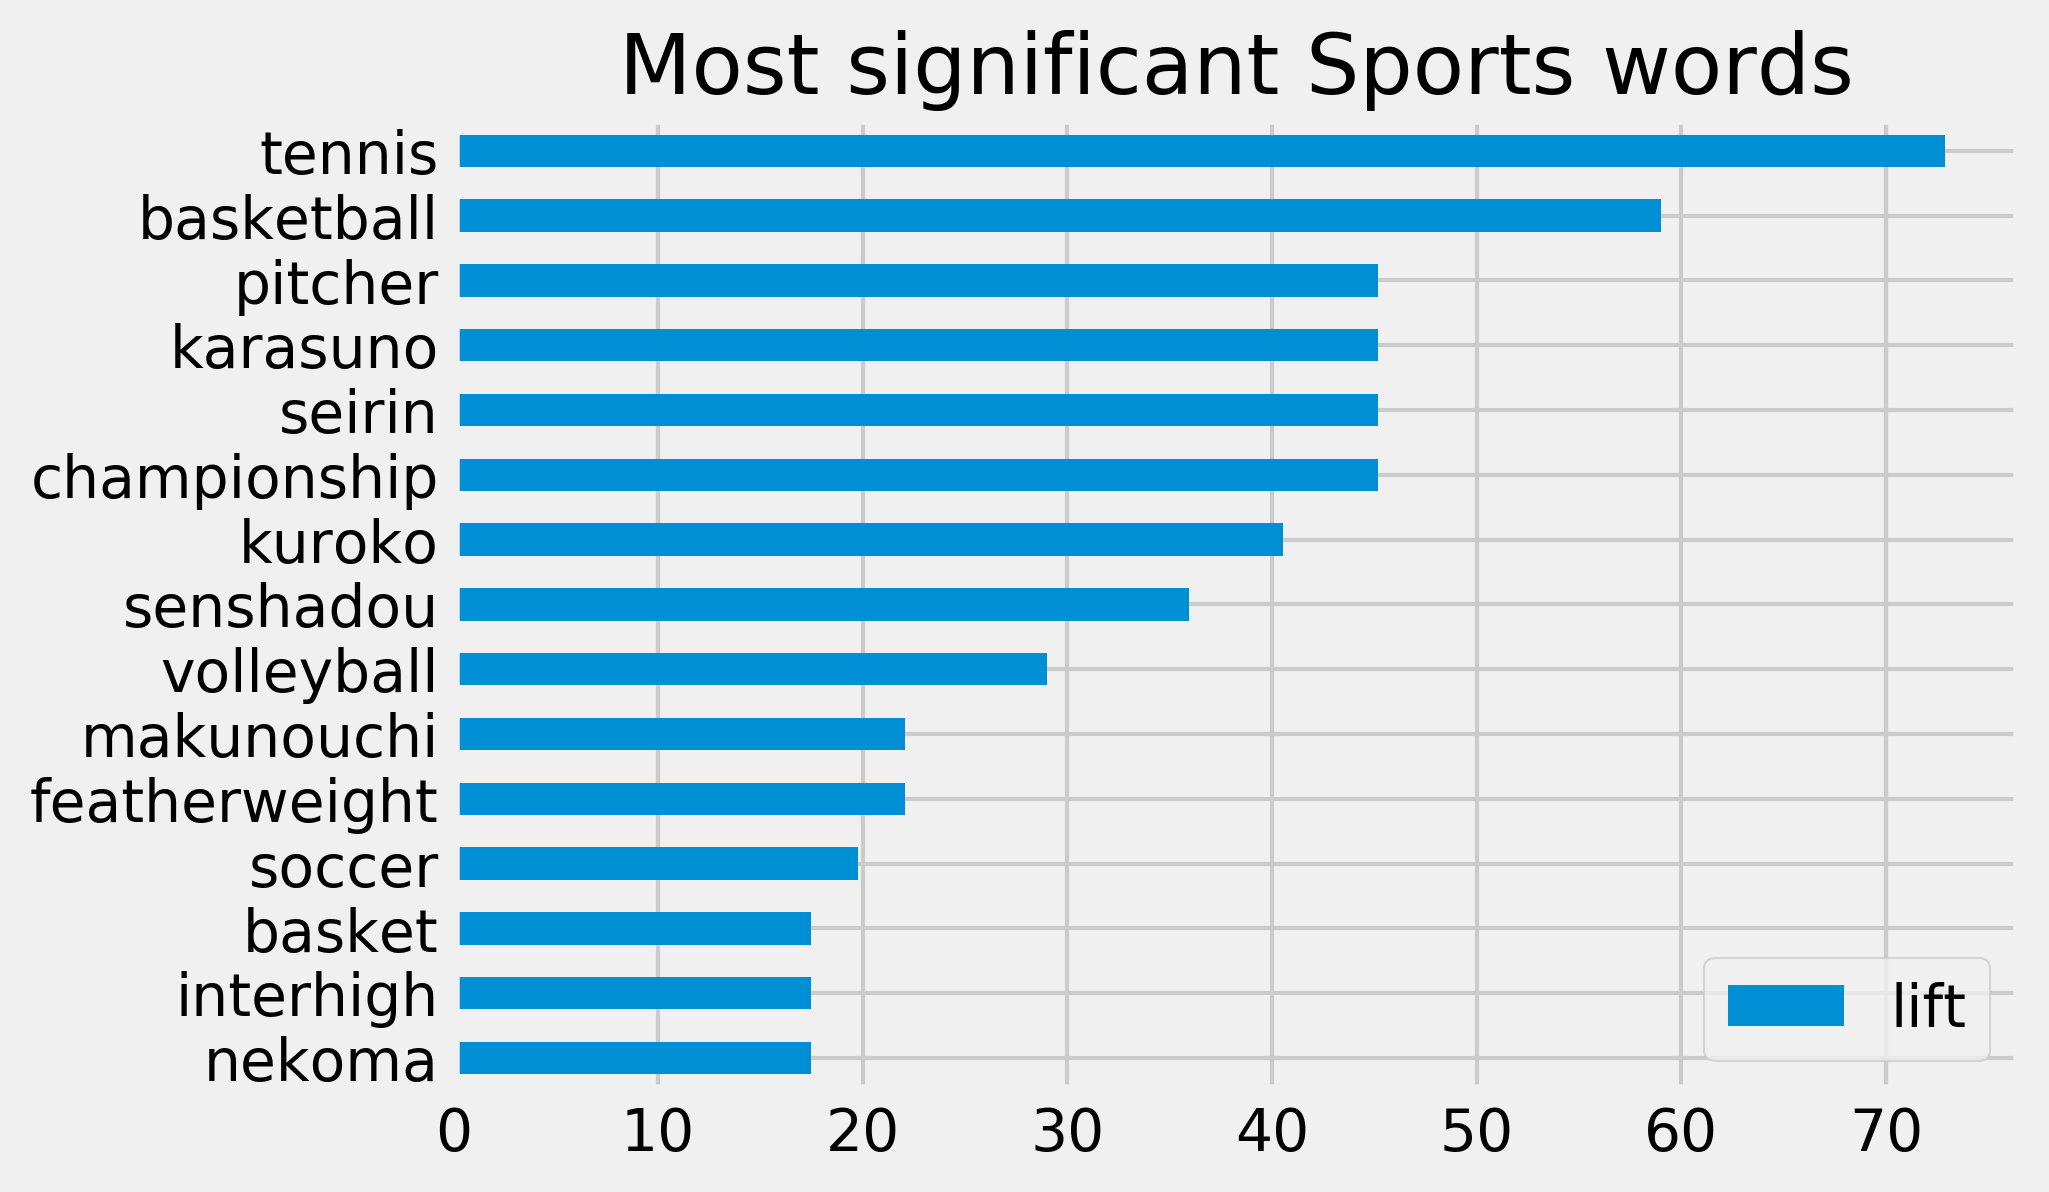

In [161]:
plot_best_words_of_genre("Sports")

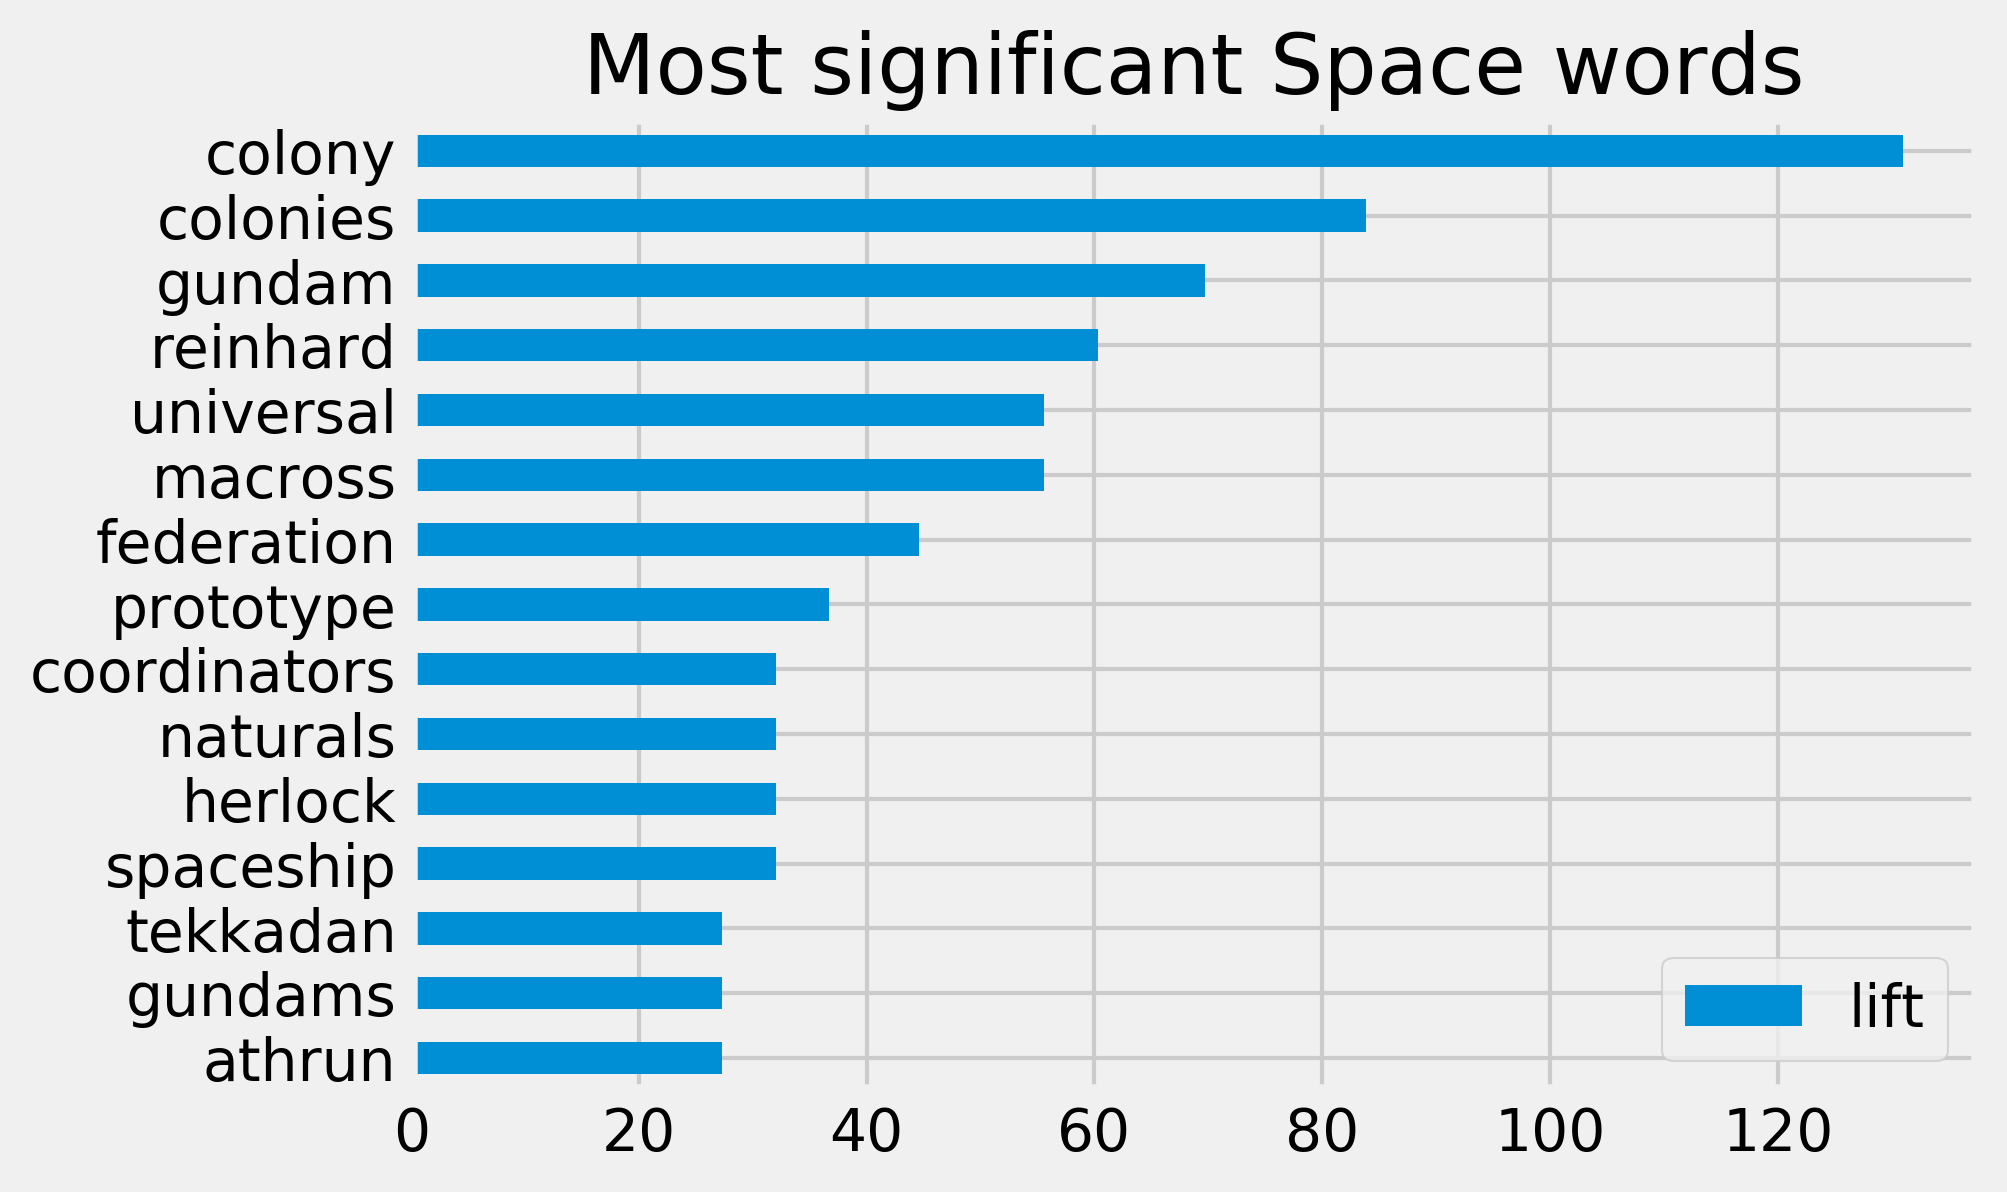

In [162]:
plot_best_words_of_genre("Space")

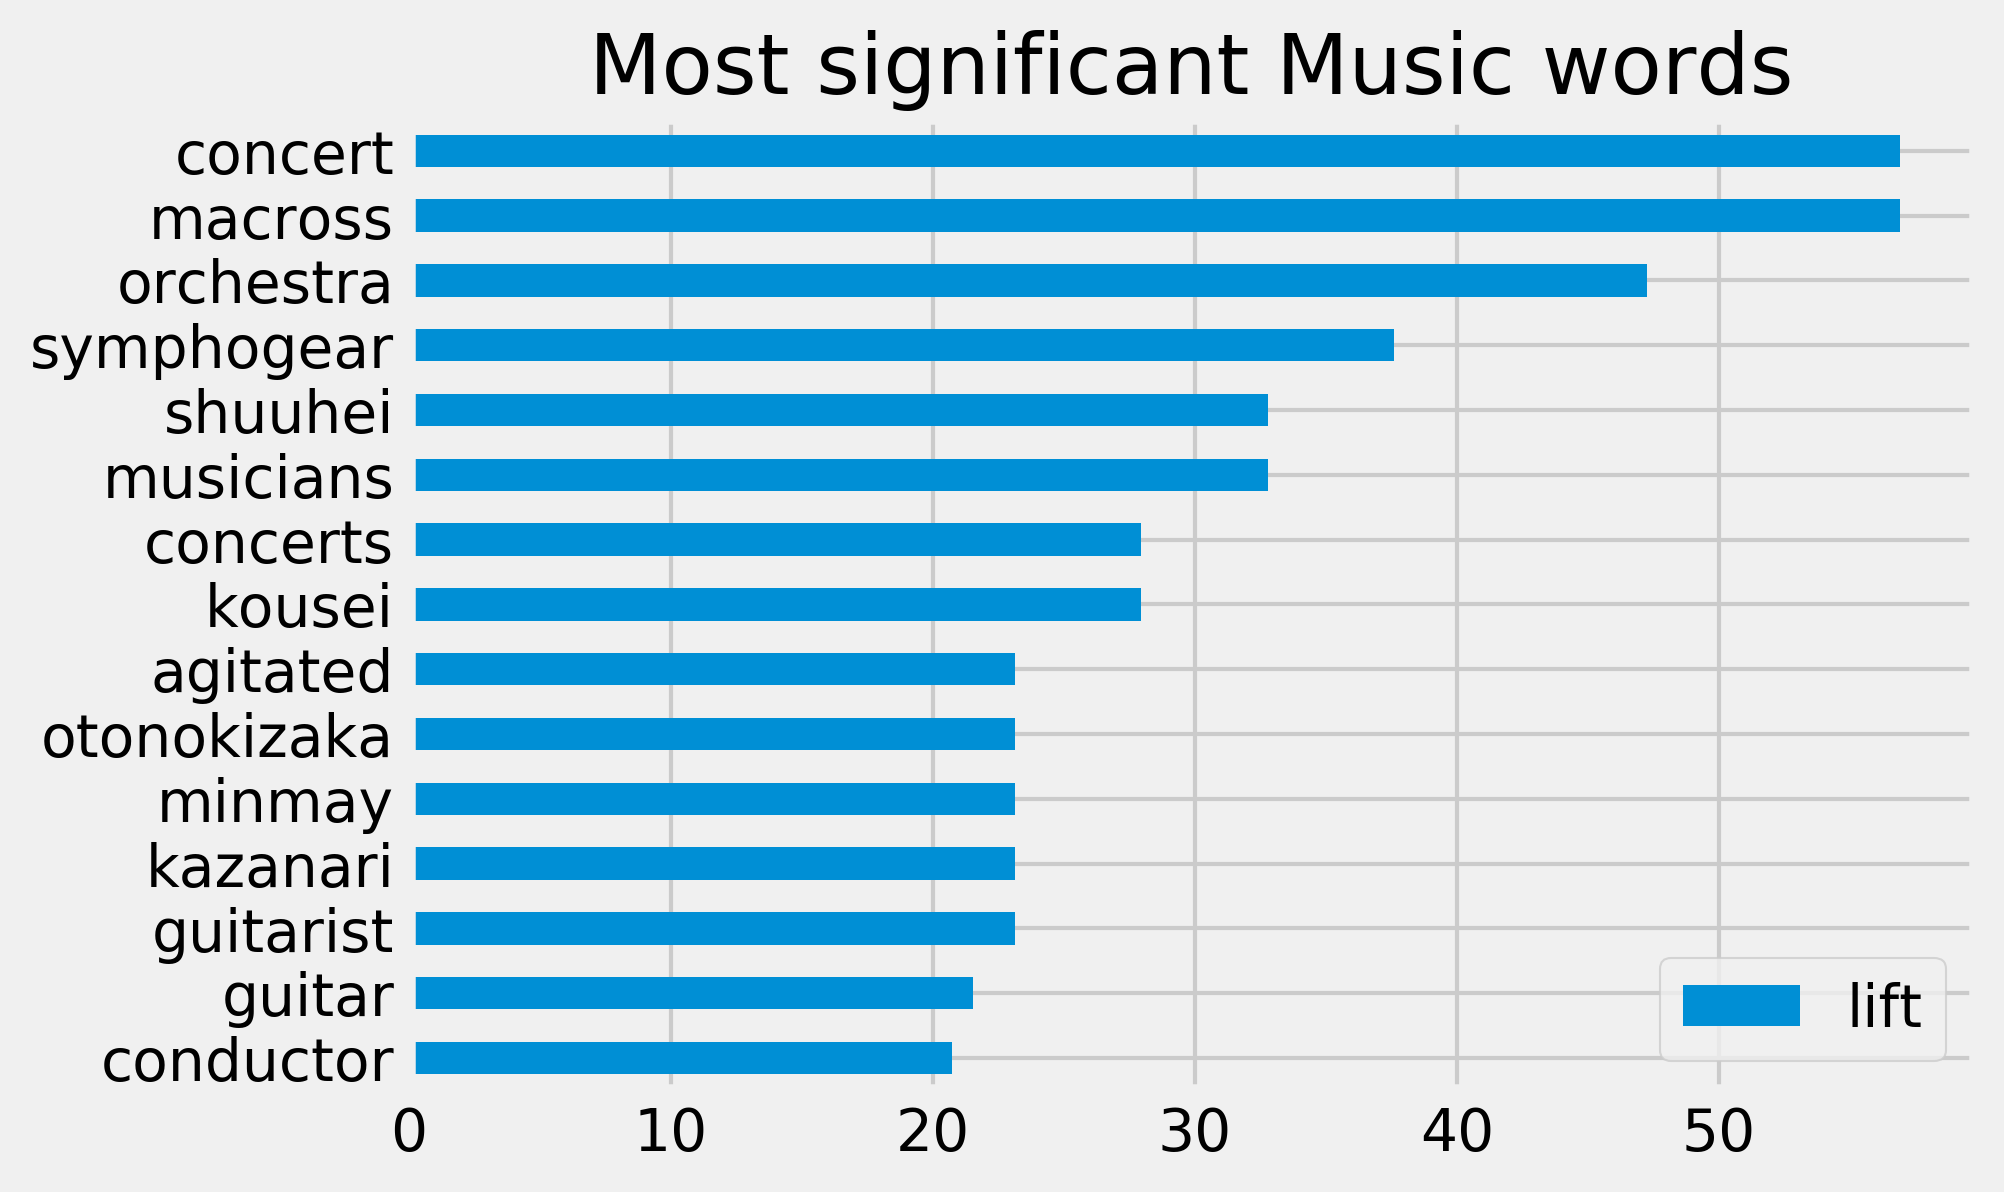

In [163]:
plot_best_words_of_genre("Music")

#### Observations
* Genres can have very exclusive words. Example: "colony" for the genre Space has a lift of around 130. It means that this word appears consistently when the anime is of the genre Space, and appears rarely when the anime is not of the genre Space.
* There are many more low lift words than there are high lift words for a given genre.
* We note two groups of words for a given genre: words that belong to the genre's vocabulary and character names. We did not manage to exclude all the names. A possible explanation might be that the same names can appear in several distinct animes of a shared genre when an anime gets multiple seasons. It therefore correlates the presence of a word to the presence of a genre. It would be particularly correlated if the genre is unpopular. Example: The Sports genre is relatively unpopular. If a Sports anime has 10 seasons featuring the same characters it might make the name of these characters extremely correlated to the Sports genre (I genuinely made this hypothesis without checking first). Let's explore this hypothesis.

In [164]:
# We saw that, for Sports animes, the name "Karasuno" is the 4th highest lift words with a lift of about 45.
karasunos = training_set_clean[training_set_clean["karasuno"] > 0]
karasunos[["title", "genres", "karasuno"]]

,title,genres,karasuno
399,Haikyuu!!,"[Comedy, Sports, Drama, School, Shounen]",1
1342,Haikyuu!! Second Season,"[Comedy, Sports, Drama, School, Shounen]",3
1435,Haikyuu!!: Karasuno Koukou vs. Shiratorizawa G...,"[Comedy, Sports, Drama, School, Shounen]",4
1499,Haikyuu!!: To the Top,"[Comedy, Sports, Drama, School, Shounen]",1


It looks like our hypothesis was correct.
The word "karasuno" appears exclusively in animes of the genre Sports, and exclusively in animes belonging to seasons of the anime "Haikyuu!!". This gives us a great example of how a character name can get a very high lift for a given genre.

## Conclusion

### What did we do?
We:
* Set our goal: getting an average accuracy per genre of at least 80%
* Fetched the data we needed
* Cleaned it
* Prepared for the Naive Bayes algorithm
* Classified our animes using the Naive Bayes algorithm
* Analyzed our accuracies per anime and per genre in details
* Looked for correlations to explore what makes genres easy or hard to predict
* Explored the relationships between genres
* Visualized the most significant words for given genres

### Is the accuracy of our algorithm satisfactory?
Given our goal of a 80% genre accuracy, it is. We obtained an average accuracy per genre of 91%.

We explored this accuracy using multiple definitions. Our algorithm is good at predicting the presence or absence of a genre, but this high accuracy is mostly due to the fact that, for an arbitrary anime, odds are that an arbitrary genre is absent.
The percentage of animes for which we predicted its genres perfectly is extremely low, but it was expected. The algorithm we use is used to focus on the presence/absence of one genre, not 43 genres together. Predicting an anime's genres perfectly means getting the right presence value for each one of the 43 genres, which is very hard to do with this algorithm.

### Some things we learned
* Using the Multinomial Naive Bayes algorithm, we can obtain a high accuracy on the prediction of a singular parameter
* We confirmed that it is not great at predicting a high number of them as a whole
* The parameters for this algorithm can take a very long time to compute as 1865 animes, 31521 unique words and 43 genres took 21 hours and 36 minutes
* We noted some interesting correlations, like the fact that the more popular a genre is, the harder it is for us to predict its genres
* It is hard to find strong relationships between genres.

## Next Steps
We could imagine many additional tasks to improve our algorithm or add to our analysis:
* Defining more precisely what a valid word is a synopsis. Maybe have a dictionary of meaningless words rather than excluding all the words of less than 5 letters? Research on the ability to recognize character names to exclude them?
* Find a way to visualize the relationship between each pair of genres. I tried to build a scatter plot where each point represents a genre, and the distance between two points is inversely proportional to the relationship between these two genres (or to log(relationship)). I ended up giving up as, with 43 genres, the system felt exceedingly hard to solve (unsolvable in some case?).
* Comparing the performance of this algorithm to other classification algorithms for similar tasks
* Repeat this whole process for another topic. Predicting movie genres from their synopses? Would it be easier?
* Try to find more correlations to explain what makes a synopsis hard to correlate with genres

## Personal Notes
I am currently in the process of learning Data Science. I learn the theory with some practice using [DataQuest](https://app.dataquest.io/) and build projects to practice extensively what I learn.

### My personal goals for this project
For this project, my personal goals were to:
* Practice using the Multinomial Naive Bayes algorithm
* Try to extend the use of this algorithm. The only example I knew before this project was classifying sms as spam or not spam. I was curious about the results I would get applying it to more than one boolean parameter, and applying to classes that are harder to clearly define.
* Practice using APIs
* Practice communication through documentation
* Complete a bigger Data Science project relatively to previous projects

### Notes
* I chose the theme of animes arbitrarily. This could have been on movies or something else. I simply bumped into a good looking anime API and thought that it could be my theme. I also thought that this is less common than movies.

## Project Duration
When I work, I keep track of the durations and the topics. That way I can monitor my motivation and how much time each part of a project takes.

In total, this project took me about 41 hours of work spread among two weeks (I worked on it on 9 of these days).

I divided the tasks in three categories:
* Proof of Concept: exploring, making sure that this project is both achievable and relevant for me
* Development: implementing each functionality & adding analyses after completing the Proof of Concept
* Documenting & Cleaning: making sure that the project is well structured, that each section is explained in details using markdown cells, and that the code is commented and clean

### Visualizing the tasks' duration

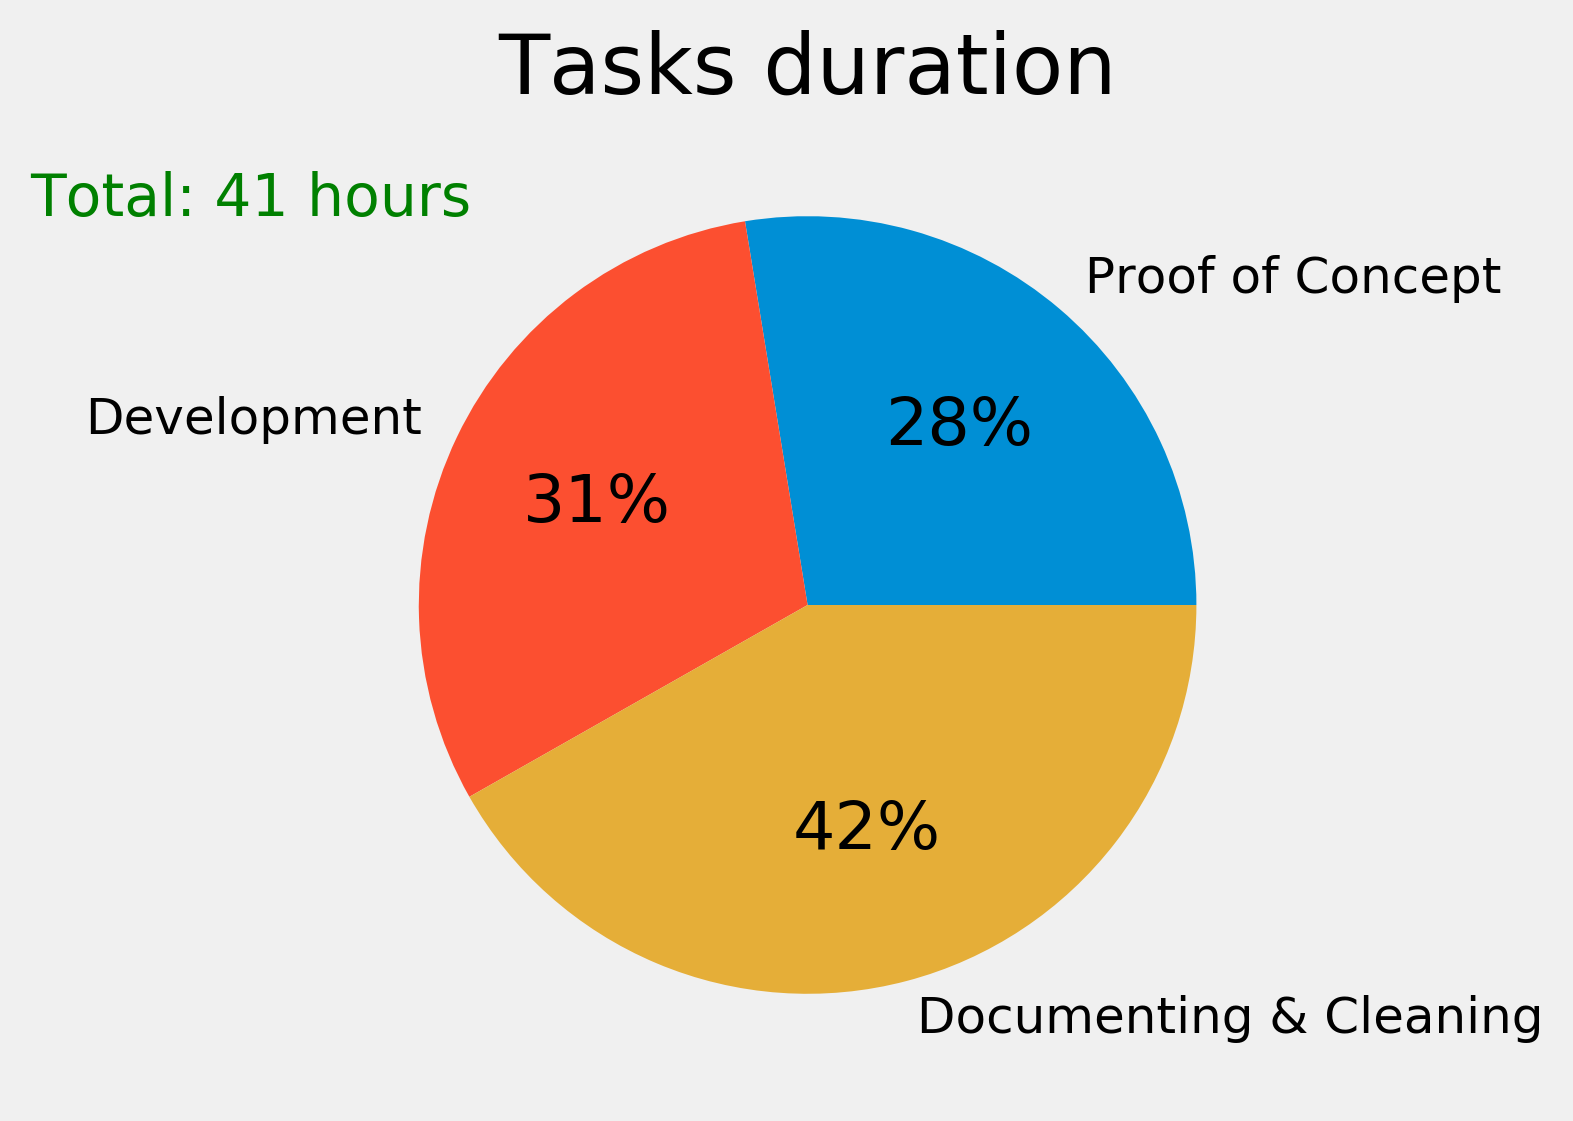

In [165]:
# Matplotlib configuration
mpl.rcParams['figure.dpi'] = 300    # tells matplotlib to display inline plots at 300 DPI
mpl.rc("savefig", dpi = 300)        # tells matplotlib to save plots at 300 DPI

# Setting up the data from the pie chart
poc_mins = 675
developing_mins = 750
doc_or_cleaning_mins = 1023
total_mins = poc_mins + developing_mins + doc_or_cleaning_mins
sizes = [poc_mins / total_mins, developing_mins / total_mins, doc_or_cleaning_mins / total_mins]
labels = ["Proof of Concept", "Development", "Documenting & Cleaning"]
title = "Tasks duration"

# Plotting
wedges, labels, autopct = plt.pie(sizes, labels = labels, autopct = '%1.0f%%');
plt.title(title);
plt.setp(labels, fontsize = 12);
plt.setp(autopct, fontsize = 16);
total_hours = round(total_mins / 60)
plt.text(-2, 1, "Total: " + str(total_hours) + " hours", color = "green");

### Comments
The time spent on this project ended up being roughly evenly distributed between the three tasks, with a sleight dominance of the Documenting & Cleaning section.
I expected to spend less time on the Proof of Concept and Documenting & Cleaning parts of the project.

Completing the Proof of Concept took this long because I could only consider it done after getting satisfactory accuracy results, which requires implementing a big part of the project first.

Documenting & Cleaning took this long as there was a need for a lot of documentation and there is a lot of code to clean.

# The end
#### I very much hope that this project was interesting to you!